# load dependencies

In [532]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid

import joblib

import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import log_loss

import shap

In [63]:
import warnings
warnings.filterwarnings('ignore')

# load the data

In [575]:
coffee_data = '../data/arabica_data_cleaned.csv'

cf = pd.read_csv(coffee_data)
cf_original = cf.copy() ## keep for justifying feature selection
cf = cf.iloc[:, 1:] # ship the number column

In [3]:
cf.head()

Species                     Owner Country.of.Origin  \
0  Arabica                 metad plc          Ethiopia   
1  Arabica                 metad plc          Ethiopia   
2  Arabica  grounds for health admin         Guatemala   
3  Arabica       yidnekachew dabessa          Ethiopia   
4  Arabica                 metad plc          Ethiopia   

                                  Farm.Name Lot.Number       Mill ICO.Number  \
0                                 metad plc        NaN  metad plc  2014/2015   
1                                 metad plc        NaN  metad plc  2014/2015   
2  san marcos barrancas "san cristobal cuch        NaN        NaN        NaN   
3     yidnekachew dabessa coffee plantation        NaN    wolensu        NaN   
4                                 metad plc        NaN  metad plc  2014/2015   

                                 Company       Altitude        Region  ...  \
0      metad agricultural developmet plc      1950-2200  guji-hambela  ...   
1      metad agricultural developmet plc      1950-2200  guji-hambela  ...   
2                                    NaN  1600 - 1800 m           NaN  ...   
3  yidnekachew debessa coffee plantation      1800-2200        oromia  ...   
4      metad agricultural developmet plc      1950-2200  guji-hambela  ...   

   Color  Category.Two.Defects        Expiration  \
0  Green                     0   April 3rd, 2016   
1  Green                     1   April 3rd, 2016   
2    NaN                     0    May 31st, 2011   
3  Green                     2  March 25th, 2016   
4  Green                     2   April 3rd, 2016   

                   Certification.Body  \
0  METAD Agricultural Development plc   
1  METAD Agricultural Development plc   
2        Specialty Coffee Association   
3  METAD Agricultural Development plc   
4  METAD Agricultural Development plc   

                      Certification.Address  \
0  309fcf77415a3661ae83e027f7e5f05dad786e44   
1  309fcf77415a3661ae83e027f7e5f05dad786e44   
2  36d0d00a3724338ba7937c52a378d085f2172daa   
3  309fcf77415a3661ae83e027f7e5f05dad786e44   
4  309fcf77415a3661ae83e027f7e5f05dad786e44   

                      Certification.Contact unit_of_measurement  \
0  19fef5a731de2db57d16da10287413f5f99bc2dd                   m   
1  19fef5a731de2db57d16da10287413f5f99bc2dd                   m   
2  0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660                   m   
3  19fef5a731de2db57d16da10287413f5f99bc2dd                   m   
4  19fef5a731de2db57d16da10287413f5f99bc2dd                   m   

  altitude_low_meters altitude_high_meters  altitude_mean_meters  
0              1950.0               2200.0                2075.0  
1              1950.0               2200.0                2075.0  
2              1600.0               1800.0                1700.0  
3              1800.0               2200.0                2000.0  
4              1950.0               2200.0                2075.0  

[5 rows x 43 columns]

In [576]:
feature_list = list(cf.columns)
feature_list

['Species',
 'Owner',
 'Country.of.Origin',
 'Farm.Name',
 'Lot.Number',
 'Mill',
 'ICO.Number',
 'Company',
 'Altitude',
 'Region',
 'Producer',
 'Number.of.Bags',
 'Bag.Weight',
 'In.Country.Partner',
 'Harvest.Year',
 'Grading.Date',
 'Owner.1',
 'Variety',
 'Processing.Method',
 'Aroma',
 'Flavor',
 'Aftertaste',
 'Acidity',
 'Body',
 'Balance',
 'Uniformity',
 'Clean.Cup',
 'Sweetness',
 'Cupper.Points',
 'Total.Cup.Points',
 'Moisture',
 'Category.One.Defects',
 'Quakers',
 'Color',
 'Category.Two.Defects',
 'Expiration',
 'Certification.Body',
 'Certification.Address',
 'Certification.Contact',
 'unit_of_measurement',
 'altitude_low_meters',
 'altitude_high_meters',
 'altitude_mean_meters']

In [580]:
feature_selected = [
    'Country.of.Origin', 'Variety', 
    'Processing.Method', 'Moisture', 
    'unit_of_measurement', 'Color', 
    'altitude_mean_meters', 'Total.Cup.Points'
]

In [581]:
cf = cf[feature_selected]
cf

KeyError: "['Country.of.Origin', 'Processing.Method', 'unit_of_measurement', 'altitude_mean_meters', 'Total.Cup.Points'] not in index"

In [582]:
cf.columns = cf.columns.str.replace('.', '_')
cf.columns = cf.columns.str.title()
cf

Country_Of_Origin  Variety Processing_Method  Moisture  \
0             Ethiopia      NaN      Washed / Wet      0.12   
1             Ethiopia    Other      Washed / Wet      0.12   
2            Guatemala  Bourbon               NaN      0.00   
3             Ethiopia      NaN     Natural / Dry      0.11   
4             Ethiopia    Other      Washed / Wet      0.12   
...                ...      ...               ...       ...   
1306            Mexico  Bourbon      Washed / Wet      0.11   
1307             Haiti   Typica     Natural / Dry      0.14   
1308         Nicaragua  Caturra             Other      0.13   
1309         Guatemala   Catuai      Washed / Wet      0.10   
1310          Honduras  Caturra               NaN      0.12   

     Unit_Of_Measurement       Color  Altitude_Mean_Meters  Total_Cup_Points  
0                      m       Green               2075.00             90.58  
1                      m       Green               2075.00             89.92  
2                      m         NaN               1700.00             89.75  
3                      m       Green               2000.00             89.00  
4                      m       Green               2075.00             88.83  
...                  ...         ...                   ...               ...  
1306                   m        None                900.00             68.33  
1307                   m  Blue-Green                350.00             67.92  
1308                   m       Green               1100.00             63.08  
1309                  ft       Green               1417.32             59.83  
1310                   m       Green               1400.00              0.00  

[1311 rows x 8 columns]

In [583]:
## data cleaning for units
unit_to_convert = cf['Unit_Of_Measurement'].eq('ft')
cf.loc[unit_to_convert, ['Altitude_Mean_Meters']] /= 3.281
cf['Unit_Of_Measurement'].replace(to_replace='ft', value='m', inplace=True)
# cf.drop(columns='unit_of_measurement')

In [584]:
cf

Country_Of_Origin  Variety Processing_Method  Moisture  \
0             Ethiopia      NaN      Washed / Wet      0.12   
1             Ethiopia    Other      Washed / Wet      0.12   
2            Guatemala  Bourbon               NaN      0.00   
3             Ethiopia      NaN     Natural / Dry      0.11   
4             Ethiopia    Other      Washed / Wet      0.12   
...                ...      ...               ...       ...   
1306            Mexico  Bourbon      Washed / Wet      0.11   
1307             Haiti   Typica     Natural / Dry      0.14   
1308         Nicaragua  Caturra             Other      0.13   
1309         Guatemala   Catuai      Washed / Wet      0.10   
1310          Honduras  Caturra               NaN      0.12   

     Unit_Of_Measurement       Color  Altitude_Mean_Meters  Total_Cup_Points  
0                      m       Green           2075.000000             90.58  
1                      m       Green           2075.000000             89.92  
2                      m         NaN           1700.000000             89.75  
3                      m       Green           2000.000000             89.00  
4                      m       Green           2075.000000             88.83  
...                  ...         ...                   ...               ...  
1306                   m        None            900.000000             68.33  
1307                   m  Blue-Green            350.000000             67.92  
1308                   m       Green           1100.000000             63.08  
1309                   m       Green            431.978055             59.83  
1310                   m       Green           1400.000000              0.00  

[1311 rows x 8 columns]

In [585]:
cf.drop(columns="Unit_Of_Measurement", inplace=True)
cf

Country_Of_Origin  Variety Processing_Method  Moisture       Color  \
0             Ethiopia      NaN      Washed / Wet      0.12       Green   
1             Ethiopia    Other      Washed / Wet      0.12       Green   
2            Guatemala  Bourbon               NaN      0.00         NaN   
3             Ethiopia      NaN     Natural / Dry      0.11       Green   
4             Ethiopia    Other      Washed / Wet      0.12       Green   
...                ...      ...               ...       ...         ...   
1306            Mexico  Bourbon      Washed / Wet      0.11        None   
1307             Haiti   Typica     Natural / Dry      0.14  Blue-Green   
1308         Nicaragua  Caturra             Other      0.13       Green   
1309         Guatemala   Catuai      Washed / Wet      0.10       Green   
1310          Honduras  Caturra               NaN      0.12       Green   

      Altitude_Mean_Meters  Total_Cup_Points  
0              2075.000000             90.58  
1              2075.000000             89.92  
2              1700.000000             89.75  
3              2000.000000             89.00  
4              2075.000000             88.83  
...                    ...               ...  
1306            900.000000             68.33  
1307            350.000000             67.92  
1308           1100.000000             63.08  
1309            431.978055             59.83  
1310           1400.000000              0.00  

[1311 rows x 7 columns]

In [586]:
cf.columns

Index(['Country_Of_Origin', 'Variety', 'Processing_Method', 'Moisture',
       'Color', 'Altitude_Mean_Meters', 'Total_Cup_Points'],
      dtype='object')

# Split

In [491]:
X = cf.iloc[:, cf.columns != "Total_Cup_Points"]
y = cf["Total_Cup_Points"]
seed = 42

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_other, y_other, test_size=0.25, shuffle=True, random_state=seed)

In [492]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(786, 6)
(262, 6)
(263, 6)


# Preprocessing

In [493]:
for col, val in zip(list(X.columns), list(X.isnull().sum())):
    print(f'for column {col}, there are {val} rows with null values')

for column Country_Of_Origin, there are 1 rows with null values
for column Variety, there are 201 rows with null values
for column Processing_Method, there are 152 rows with null values
for column Moisture, there are 0 rows with null values
for column Color, there are 216 rows with null values
for column Altitude_Mean_Meters, there are 227 rows with null values


In [20]:
y.isnull().sum()

0

In [571]:
oh_ftr_list = ['Country_Of_Origin', 'Variety',
               'Processing_Method', 'Color']
std_ftr_list = ["Moisture", "Altitude_Mean_Meters"]

categorical_transformer = Pipeline(
    steps=
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ]
)

numerical_transformer = Pipeline(
    steps=[
    ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, oh_ftr_list), 
        ('num', numerical_transformer, std_ftr_list)
    ]
)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)
X_val_prep = preprocessor.transform(X_val)
feature_names = preprocessor.get_feature_names_out()
feature_names

KeyError: "None of [Index(['Country_Of_Origin', 'Variety', 'Processing_Method', 'Color'], dtype='object')] are in the [columns]"

In [495]:
df_train = pd.DataFrame(X_train_prep, columns=feature_names)
df_test = pd.DataFrame(X_test_prep, columns=feature_names)
df_val = pd.DataFrame(X_val_prep, columns=feature_names)

In [496]:
## after preprocessing, only Altitude_Mean_Meters has null values
print(list(df_train.isnull().sum()))
print(list(df_val.isnull().sum()))
print(list(df_test.isnull().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 148]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40]


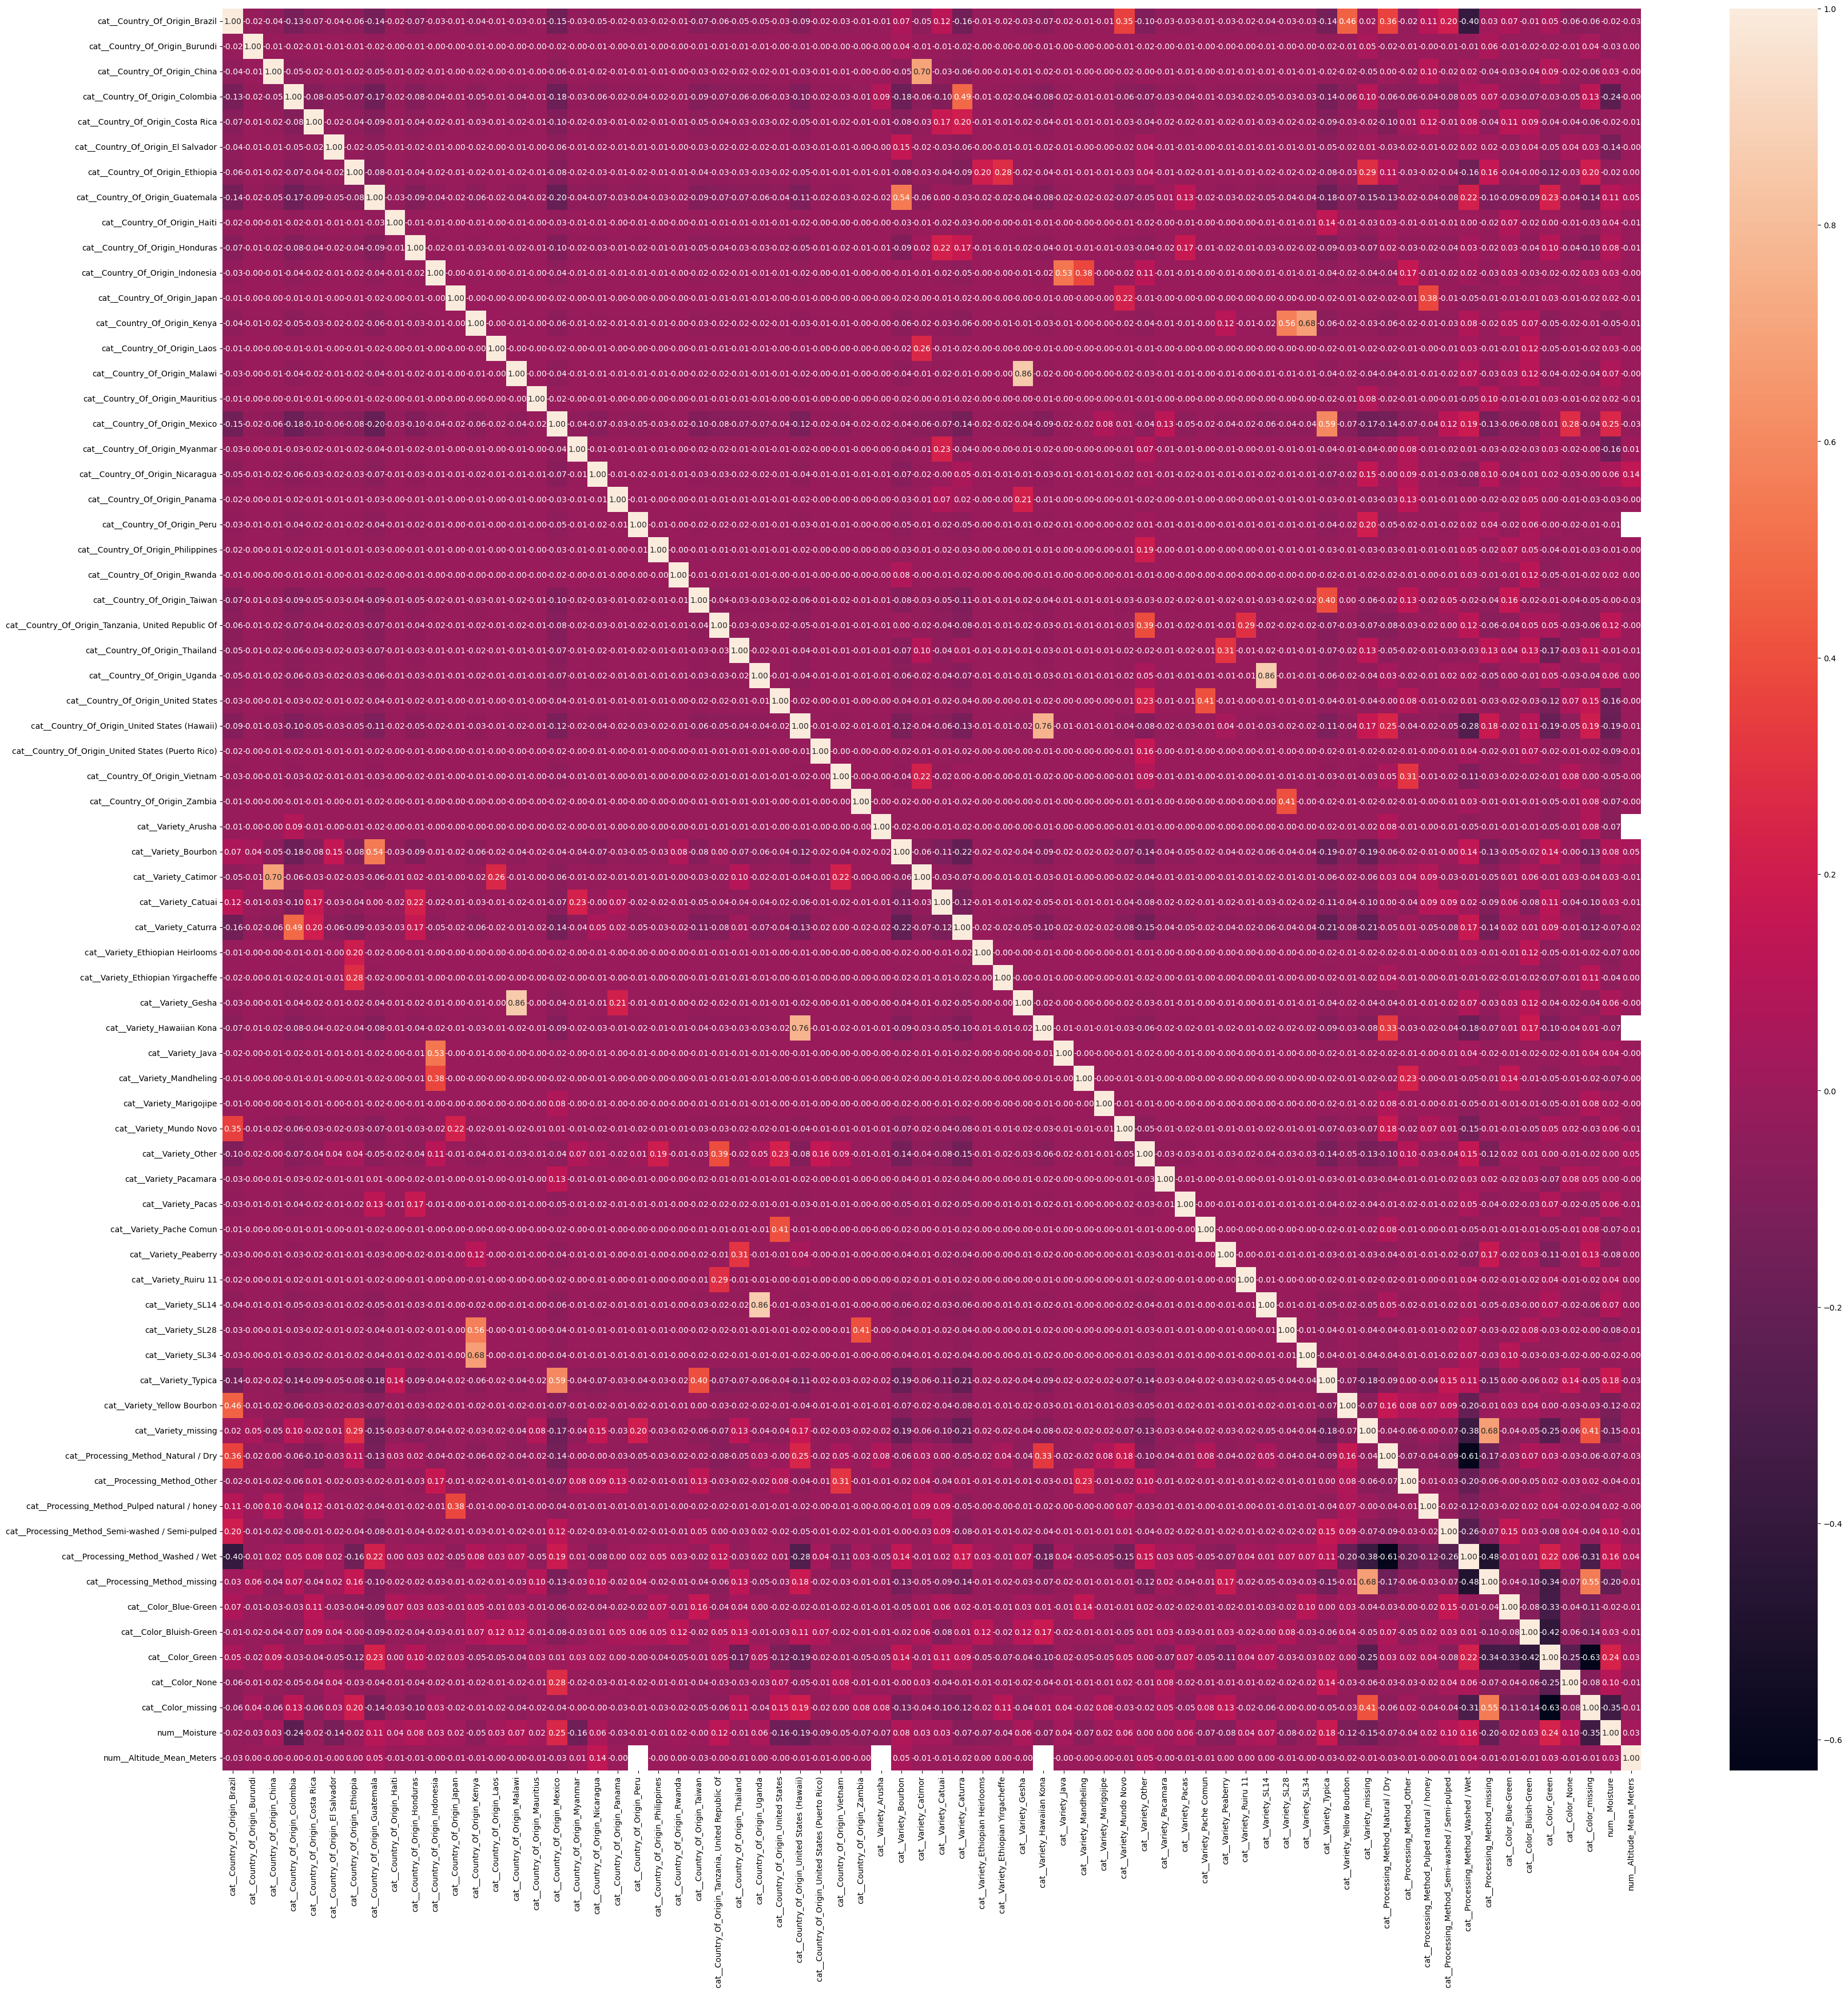

In [72]:
## this graph is too large, so for each type of categorical values, we just select three of them
df_train.corr()
plt.figure(figsize=(40, 40))
sb.heatmap(df_train.corr(), annot=True, fmt='.2f',
           xticklabels=feature_names, yticklabels=feature_names)
plt.show()

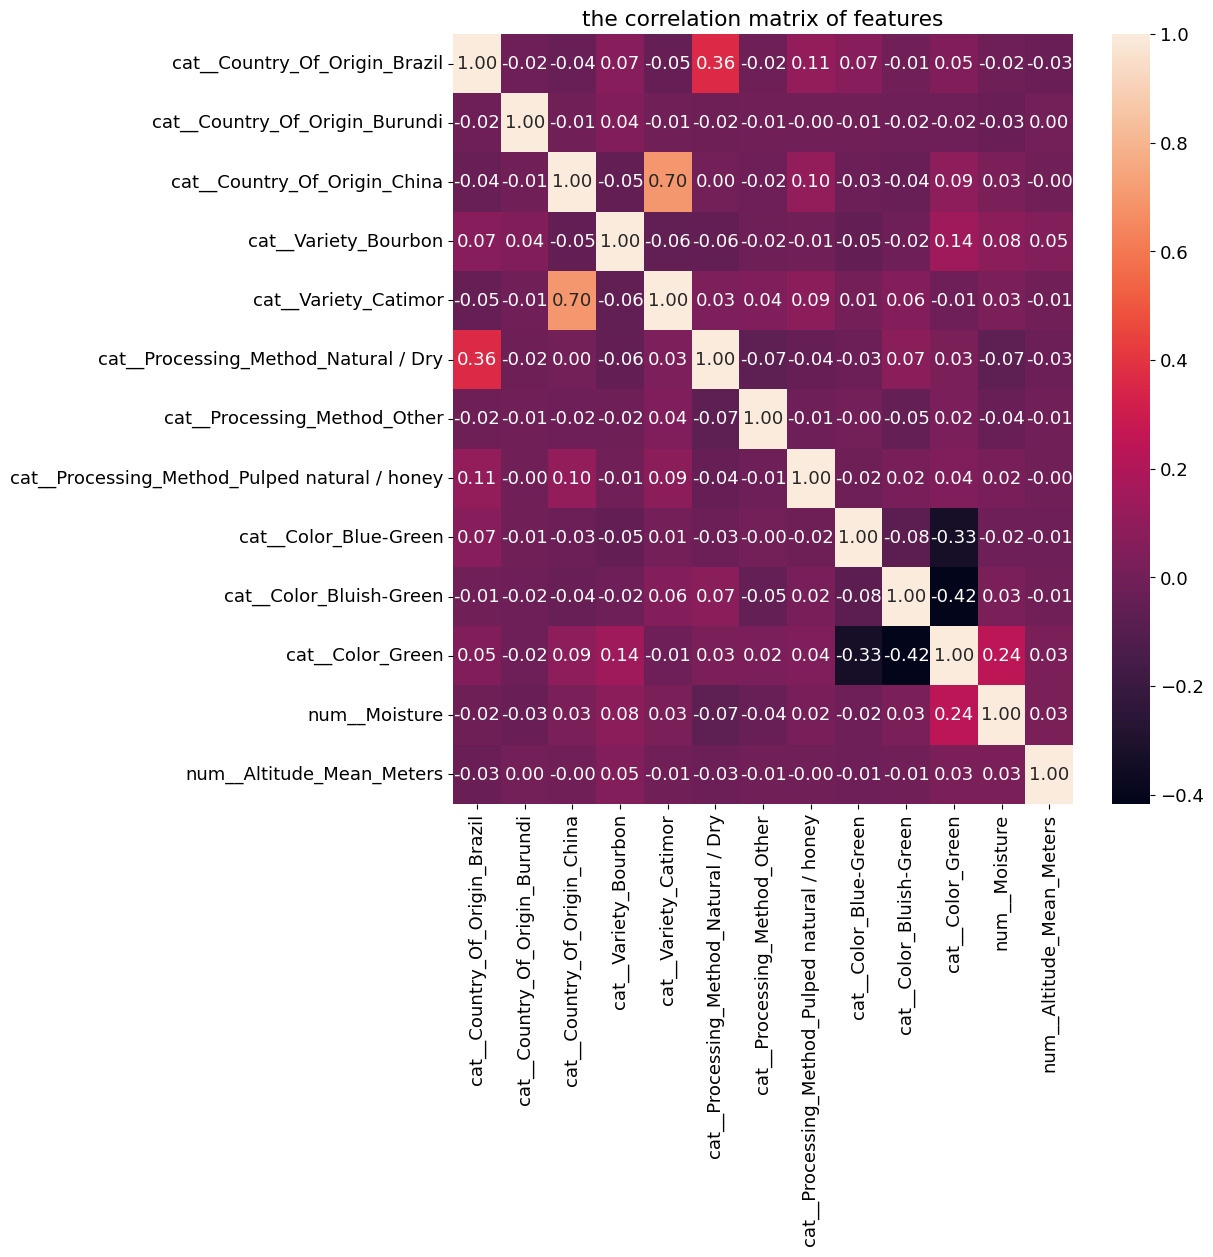

In [498]:
ftrs_corr = [
    'cat__Country_Of_Origin_Brazil', 'cat__Country_Of_Origin_Burundi',
       'cat__Country_Of_Origin_China', 
       'cat__Variety_Bourbon',
       'cat__Variety_Catimor', 
       'cat__Processing_Method_Natural / Dry',
       'cat__Processing_Method_Other',
       'cat__Processing_Method_Pulped natural / honey',
       'cat__Color_Blue-Green',
       'cat__Color_Bluish-Green', 'cat__Color_Green', 'num__Moisture', 'num__Altitude_Mean_Meters'
]
corr_mat = df_train[ftrs_corr].corr().values
plt.figure(figsize=(10, 10))
sb.heatmap(corr_mat, annot=True, fmt='.2f',
           xticklabels=ftrs_corr, yticklabels=ftrs_corr, 
          vmax=np.nanmax(corr_mat), vmin=np.nanmin(corr_mat))
plt.title("the correlation matrix of features")
plt.savefig(fname="../figure/correlation_matrix.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [53]:
df_ftr = df_train[['cat__Country_Of_Origin_China', 'cat__Variety_Catimor']]
print(df_ftr[df_ftr['cat__Country_Of_Origin_China'] == 1])
print(df_ftr[df_ftr['cat__Variety_Catimor'] == 1])

     cat__Country_Of_Origin_China  cat__Variety_Catimor
123                           1.0                   0.0
180                           1.0                   1.0
221                           1.0                   1.0
243                           1.0                   1.0
351                           1.0                   1.0
360                           1.0                   1.0
435                           1.0                   0.0
477                           1.0                   1.0
546                           1.0                   1.0
623                           1.0                   1.0
663                           1.0                   1.0
     cat__Country_Of_Origin_China  cat__Variety_Catimor
8                             0.0                   1.0
71                            0.0                   1.0
102                           0.0                   1.0
180                           1.0                   1.0
221                           1.0               

# hyperparameter tuning

In our initial try, we just drop those rows with null continuous values

In [588]:
## for algorithms other than xgboost, drop those rows with null continuous values
cf_ = cf[(~cf["Moisture"].isnull()).values & (~cf["Altitude_Mean_Meters"].isnull()).values]
X = cf_.iloc[:, cf_.columns!="Total_Cup_Points"]
y = cf_["Total_Cup_Points"]

## define some modular functions

In [56]:
def get_preprocessor():
    oh_ftr_list = ['Country_Of_Origin', 'Variety',
                   'Processing_Method', 'Color']
    std_ftr_list = ["Moisture", "Altitude_Mean_Meters"]
    
    categorical_transformer = Pipeline(
        steps=
        [
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
        ]
    )
    
    numerical_transformer = Pipeline(
        steps=[
        ("imputer", IterativeImputer())
        ("scaler", StandardScaler())
        ]
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, oh_ftr_list), 
            ('num', numerical_transformer, std_ftr_list)
        ]
    )
    return preprocessor

In [57]:
def get_splited_data(X, y, test_size, seed):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    return X_other, X_test, y_other, y_test

In [58]:
def model_result(model, model_name, X_test, y_test):
    if (model_name == "baseline"):
        y_test_pred = np.full(y_test.shape, y_test.mean())
    else:
        y_test_pred = model.predict(X_test)
        
    MAE = mean_absolute_error(y_test, y_test_pred)
    MSE = mean_squared_error(y_test, y_test_pred)
    RMSE = mean_squared_error(y_test, y_test_pred, squared=False)
    R2 = r2_score(y_test, y_test_pred)
    
    result = pd.DataFrame(
        data=[[model_name, MAE, MSE, RMSE, R2]],
        columns=["Model", "MAE", "MSE", "RMSE", "R2 Score"]
    )
    return result

In [59]:
def save_model(models, model_name):
    for i in range(len(models)):
        model = models[i]
        print(f"saving model : {model_name}_{i}")
        filepath = f"../model/{model_name}_{i}"
        model.save_model(fname=filepath)

In [80]:
def save_best_model(best_model, model_name):
    print(f"saving model : {model_name}")
    filename = f"../model/{model_name}_best.pkl"
    joblib.dump(best_model, filename)

In [79]:
def load_model(filepath):
    print(f"loading {filepath}...")
    return joblib.load(filepath)

In [596]:
def ML_pipeline(X, y, preprocessor, model, model_name, param_grid, n_rounds, seed):
    ## fix the random state for all numpy seed-based random methods
    np.random.seed(seed)
    ## generate n_rounds seeds
    random_states = np.random.randint(1, 100, n_rounds)
    
    grid_size = len(ParameterGrid(param_grid))
    test_loss = np.empty(n_rounds)
    final_models = []
    test_sets = []
    test_labels = []
    
    cv_report = pd.DataFrame()
    for i in range(n_rounds):
        random_state = random_states[i]
        print(f"\nthe {i+1}/{n_rounds} round of grid search")
        X_other, X_test, y_other, y_test = get_splited_data(X, y, 0.2, random_state)
        test_sets.append(X_test)
        test_labels.append(y_test)
        
        ## after the KFold split, the training, val, and test sets should be 0.6:0.2:0.2
        kf = KFold(n_splits=4, shuffle=True, random_state=random_state)
        
        ## set model's random_state if possible
        try:
            model.set_params(**{"random_state" : random_state})
        except ValueError:
            print("random state set failed, the model itself doesn't support this feature")
            
        pipe = make_pipeline(preprocessor, model)
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_squared_error',
                           cv=kf, return_train_score=True, n_jobs=-1, verbose=True)
        grid.fit(X_other, y_other)
        
        print('best model parameters in this round:', grid.best_params_)
        print('best model score in this round:', grid.best_score_)
        if cv_report.empty:
            cv_report = pd.DataFrame(grid.cv_results_)
        else:
            cv_report = cv_report.append(pd.DataFrame(grid.cv_results_))
        
        ## best model for this random_state
        final_models.append(grid)
        
        y_test_pred = final_models[-1].predict(X_test)
        test_loss[i] = mean_squared_error(y_test, y_test_pred)
        print('test loss:', test_loss[i])
    
    ## best model found in the GridSearchCV
    best_index = np.argmin(test_loss)
    best_model = final_models[best_index]
    best_model_result = model_result(best_model, model_name, test_sets[best_index], test_labels[best_index])
    predicts = pd.DataFrame()
    predicts["label"] = test_labels[best_index]
    predicts["predicted"] = best_model.predict(test_sets[best_index])
    predicts.to_csv(f"../results/predicts/{model_name}_best_predict.csv")
    
    cv_report.to_csv(f"../results/cv_reports/{model_name}_cv_report.csv")
    
    save_best_model(best_model, model_name)
        
    return test_loss, final_models, best_model_result, best_model, cv_report

## Baseline 

In [84]:
baseline_result = model_result(None, "baseline", X, y)
baseline_result

Model       MAE        MSE      RMSE  R2 Score
0  baseline  1.845895  13.196864  3.632749       0.0

## Linear Regression

In [597]:
random_state=42
param_grid = {}

LR_test_loss, LR_final_models, \
LR_best_model_result, LR_best_model, \
LR_cv_report= ML_pipeline(X, y, preprocessor, LinearRegression(), "Linear Regression", param_grid, 10, seed=random_state)


the 1/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 1 candidates, totalling 4 fits
best model parameters in this round: {}
best model score in this round: -4.820300523959686e+21
test loss: 1.0778488274458757e+25

the 2/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 1 candidates, totalling 4 fits
best model parameters in this round: {}
best model score in this round: -2.796439356297169e+23
test loss: 1.658997598244944e+19

the 3/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 1 candidates, totalling 4 fits
best model parameters in this round: {}
best model score in this round: -2.2175274469535957e+24
test loss: 2.9539155107065777e+24

the 4/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 

the cross validation report of Linear Regression models

In [124]:
LR_cv_report

mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
0       0.011074      0.001038         0.003533        0.000218     {}   
0       0.006184      0.000223         0.002455        0.000189     {}   
0       0.005732      0.000109         0.003358        0.000910     {}   
0       0.005512      0.000120         0.002233        0.000112     {}   
0       0.005966      0.001078         0.002181        0.000143     {}   
0       0.005448      0.000167         0.002053        0.000058     {}   
0       0.005380      0.000098         0.001956        0.000067     {}   
0       0.005226      0.000096         0.001898        0.000067     {}   
0       0.005236      0.000098         0.001956        0.000060     {}   
0       0.005073      0.000070         0.001924        0.000060     {}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0      -1.068893e+22      -1.065392e+19      -1.016723e+21      -7.564894e+21   
0      -1.625091e+23      -5.991838e+23      -5.883309e+19      -3.568239e+23   
0      -8.381814e+24      -4.463232e+22      -4.131571e+23      -3.050651e+22   
0      -4.116650e+23      -5.379452e+23      -4.972911e+23      -2.744986e+22   
0      -9.040113e+23      -5.852637e+23      -1.431531e+24      -3.713101e+01   
0      -1.918512e+23      -2.833529e+25      -8.780323e+22      -3.599954e+22   
0      -9.601680e+22      -2.045799e+24      -1.082501e+23      -3.996551e+21   
0      -4.205459e+22      -1.328119e+22      -1.756594e+26      -1.116894e+23   
0      -3.285798e+22      -1.045401e+22      -2.393436e+23      -1.750800e+20   
0      -3.285798e+22      -1.045401e+22      -2.393436e+23      -1.750800e+20   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0    -4.820301e+21    4.460199e+21                1          -13.593723   
0    -2.796439e+23    2.235793e+23                1           -4.424114   
0    -2.217527e+24    3.562257e+24                1           -5.249426   
0    -3.685878e+23    2.021616e+23                1           -5.090739   
0    -7.302016e+23    5.187183e+23                1          -14.160402   
0    -7.162736e+24    1.222411e+25                1          -14.096376   
0    -5.635156e+23    8.567449e+23                1           -4.901341   
0    -4.395660e+25    7.603864e+25                1          -14.828511   
0    -7.070768e+22    9.807654e+22                1          -14.757164   
0    -7.070768e+22    9.807654e+22                1          -14.757164   

   split1_train_score  split2_train_score  split3_train_score  \
0          -13.808177          -13.732840           -4.371931   
0          -14.517385          -14.515435          -14.186585   
0           -4.251097           -4.676627           -5.025376   
0           -4.789781           -5.368260           -5.408097   
0          -13.819487          -14.039452           -4.798097   
0          -13.410648          -14.648603           -4.750504   
0           -5.419797           -5.220444           -4.509691   
0           -4.395269          -14.269191          -13.829204   
0          -14.178973          -13.578185           -4.721216   
0          -14.178973          -13.578185           -4.721216   

   mean_train_score  std_train_score  
0        -11.376668         4.044919  
0        -11.910880         4.324583  
0         -4.800631         0.377257  
0         -5.164219         0.248351  
0        -11.704359         3.989205  
0        -11.726533         4.051416  
0         -5.012818         0.344349  
0        -11.830544         4.307342  
0        -11.808884         4.113245  
0        -11.808884         4.113245

the parameter of the best model in the total gridsearch

In [130]:
LR_best_model.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=KFold(n_splits=4, random_state=87, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                              

In [131]:
LR_best_model.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Country_Of_Origin',
                                                   'Variety',
                                                   'Processing_Method',
                                                   'Color']),
                                 

the result of the best model

In [119]:
LR_best_model_result

Model       MAE       MSE      RMSE  R2 Score
0  Linear Regression  1.649634  5.755843  2.399134  0.180812

In [121]:
LR_test_loss

array([1.07784883e+25, 1.65899760e+19, 2.95391551e+24, 6.03966453e+22,
       8.44628536e+24, 1.08706665e+23, 6.06562385e+23, 5.75584271e+00,
       8.09300672e+23, 8.09300672e+23])

## Rdige

In [598]:
random_state=42
param_grid = {
    "ridge__alpha" : np.logspace(0, 3, 10),
    "ridge__solver" : ["saga"],
    "ridge__max_iter" : [100000]
}

Ridge_test_loss, Ridge_final_models, \
Ridge_best_model_result, Ridge_best_model, \
Ridge_cv_report = ML_pipeline(X, y, preprocessor, Ridge(), "Ridge", param_grid, 10, seed=random_state)


the 1/10 round of grid search
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters in this round: {'ridge__alpha': 10.0, 'ridge__max_iter': 100000, 'ridge__solver': 'saga'}
best model score in this round: -13.125777316051009
test loss: 8.01167684526125

the 2/10 round of grid search
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters in this round: {'ridge__alpha': 1000.0, 'ridge__max_iter': 100000, 'ridge__solver': 'saga'}
best model score in this round: -19.077681101784133
test loss: 6.079632889214753

the 3/10 round of grid search
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters in this round: {'ridge__alpha': 2.154434690031884, 'ridge__max_iter': 100000, 'ridge__solver': 'saga'}
best model score in this round: -5.786654840092314
test loss: 36.504331165335216

the 4/10 round of grid search
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters in this round: {'

the cross validation report of ridge models

In [137]:
Ridge_cv_report.to_csv("../cv_reports/Ridge_cv_report.csv")
Ridge_cv_report.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.133244      0.018063         0.004202        0.001504   
1       0.095378      0.021159         0.002490        0.000350   
2       0.073986      0.031788         0.004142        0.002027   
3       0.054219      0.021006         0.004106        0.001980   
4       0.030731      0.001936         0.002121        0.000133   

  param_ridge__alpha param_ridge__max_iter param_ridge__solver  \
0                1.0                100000                saga   
1           2.154435                100000                saga   
2           4.641589                100000                saga   
3               10.0                100000                saga   
4          21.544347                100000                saga   

                                              params  split0_test_score  \
0  {'ridge__alpha': 1.0, 'ridge__max_iter': 10000...          -6.494387   
1  {'ridge__alpha': 2.154434690031884, 'ridge__ma...          -6.412000   
2  {'ridge__alpha': 4.641588833612778, 'ridge__ma...          -6.312735   
3  {'ridge__alpha': 10.0, 'ridge__max_iter': 1000...          -6.187648   
4  {'ridge__alpha': 21.544346900318832, 'ridge__m...          -6.064151   

   split1_test_score  ...  split3_test_score  mean_test_score  std_test_score  \
0          -5.450569  ...         -35.748556       -13.340583       12.943106   
1          -5.355814  ...         -35.657502       -13.263230       12.935153   
2          -5.233814  ...         -35.597720       -13.182014       12.947566   
3          -5.115637  ...         -35.638097       -13.125777       13.003070   
4          -5.048126  ...         -35.807434       -13.127848       13.099000   

   rank_test_score  split0_train_score  split1_train_score  \
0                7          -13.698448          -14.052486   
1                5          -13.775959          -14.116335   
2                3          -13.890953          -14.234657   
3                1          -14.071182          -14.439803   
4                2          -14.354248          -14.733864   

   split2_train_score  split3_train_score  mean_train_score  std_train_score  
0          -13.917870           -4.497648        -11.541613         4.068797  
1          -13.991720           -4.565812        -11.612457         4.070204  
2          -14.106159           -4.684850        -11.729155         4.068885  
3          -14.296282           -4.853238        -11.915126         4.079299  
4          -14.571560           -5.056312        -12.178996         4.114488  

[5 rows x 21 columns]

the parameter of the best model in the total gridsearch

In [138]:
Ridge_best_model.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=KFold(n_splits=4, random_state=75, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                              

the result of the best model

In [139]:
Ridge_best_model_result

Model       MAE       MSE      RMSE  R2 Score
0  Ridge  1.612715  4.875113  2.207966  0.176414

In [140]:
Ridge_test_loss

array([ 8.01167685,  6.07963289, 36.50433117, 35.61831132,  6.08890482,
        5.17543757, 35.27751522,  5.97303216,  4.87511314,  4.87511314])

## Lasso

In [599]:
random_state=42
param_grid = {
    "lasso__alpha" : np.logspace(-1, 3, 10),
    "lasso__max_iter" : [100000],
    "lasso__selection" : ["cyclic", "random"]
}

Lasso_test_loss, Lasso_final_models, \
Lasso_best_model_result, Lasso_best_model, \
Lasso_cv_report = ML_pipeline(X, y, preprocessor, Lasso(), "Lasso", param_grid, 10, seed=random_state)


the 1/10 round of grid search
Fitting 4 folds for each of 20 candidates, totalling 80 fits
best model parameters in this round: {'lasso__alpha': 0.1, 'lasso__max_iter': 100000, 'lasso__selection': 'cyclic'}
best model score in this round: -13.53989815822869
test loss: 9.212496453671147

the 2/10 round of grid search
Fitting 4 folds for each of 20 candidates, totalling 80 fits
best model parameters in this round: {'lasso__alpha': 0.774263682681127, 'lasso__max_iter': 100000, 'lasso__selection': 'cyclic'}
best model score in this round: -14.936456932464427
test loss: 6.424855000936049

the 3/10 round of grid search
Fitting 4 folds for each of 20 candidates, totalling 80 fits
best model parameters in this round: {'lasso__alpha': 0.1, 'lasso__max_iter': 100000, 'lasso__selection': 'cyclic'}
best model score in this round: -6.571227902411295
test loss: 37.43947001173558

the 4/10 round of grid search
Fitting 4 folds for each of 20 candidates, totalling 80 fits
best model parameters in this

the cross validation report of Lasso models

In [142]:
Lasso_cv_report.to_csv("../cv_reports/Lasso_cv_report.csv")
Lasso_cv_report.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.007442      0.000172         0.003605        0.000336   
1       0.011077      0.002671         0.006020        0.000749   
2       0.012722      0.002417         0.005273        0.003317   
3       0.009323      0.002166         0.004120        0.001972   
4       0.006132      0.002302         0.003150        0.001902   

  param_lasso__alpha param_lasso__max_iter param_lasso__selection  \
0                1.0                100000                 cyclic   
1                1.0                100000                 random   
2           2.154435                100000                 cyclic   
3           2.154435                100000                 random   
4           4.641589                100000                 cyclic   

                                              params  split0_test_score  \
0  {'lasso__alpha': 1.0, 'lasso__max_iter': 10000...          -6.696452   
1  {'lasso__alpha': 1.0, 'lasso__max_iter': 10000...          -6.696452   
2  {'lasso__alpha': 2.154434690031884, 'lasso__ma...          -6.696452   
3  {'lasso__alpha': 2.154434690031884, 'lasso__ma...          -6.696452   
4  {'lasso__alpha': 4.641588833612778, 'lasso__ma...          -6.696452   

   split1_test_score  ...  split3_test_score  mean_test_score  std_test_score  \
0          -5.948028  ...         -37.023632       -14.093952       13.242036   
1          -5.948028  ...         -37.023632       -14.093952       13.242036   
2          -5.948028  ...         -37.023632       -14.093952       13.242036   
3          -5.948028  ...         -37.023632       -14.093952       13.242036   
4          -5.948028  ...         -37.023632       -14.093952       13.242036   

   rank_test_score  split0_train_score  split1_train_score  \
0                1          -16.487217           -16.73606   
1                1          -16.487217           -16.73606   
2                1          -16.487217           -16.73606   
3                1          -16.487217           -16.73606   
4                1          -16.487217           -16.73606   

   split2_train_score  split3_train_score  mean_train_score  std_train_score  
0          -16.496754           -6.417296        -14.034332         4.398828  
1          -16.496754           -6.417296        -14.034332         4.398828  
2          -16.496754           -6.417296        -14.034332         4.398828  
3          -16.496754           -6.417296        -14.034332         4.398828  
4          -16.496754           -6.417296        -14.034332         4.398828  

[5 rows x 21 columns]

In [143]:
Lasso_best_model.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=KFold(n_splits=4, random_state=21, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                              

In [145]:
Lasso_best_model_result

Model       MAE      MSE      RMSE  R2 Score
0  Lasso  1.685894  5.63198  2.373179 -0.000009

In [146]:
Lasso_test_loss

array([ 9.85004822,  6.424855  , 37.72073368, 36.38930839,  6.80346548,
        5.63197956, 36.30631481,  7.07093852,  6.00402707,  6.00402707])

## ElasticNet

In [600]:
random_state=42
param_grid = {
    "elasticnet__alpha" : np.logspace(-1, 3, 10),
    "elasticnet__l1_ratio" : np.linspace(0, 1, 5),
    "elasticnet__max_iter" : [100000],
    "elasticnet__selection" : ["cyclic", "random"]
}

ENet_test_loss, ENet_final_models, \
ENet_best_model_result, ENet_best_model, \
ENet_cv_report = ML_pipeline(X, y, preprocessor, ElasticNet(), "ElasticNet", param_grid, 10, seed=random_state)


the 1/10 round of grid search
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.035e+03, tolerance: 1.072e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.107e+03, tolerance: 1.088e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.328e+03, tolerance: 1.088e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.239e+03, tolerance: 1.072e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.417e+03, tolerance: 1.088e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.336e+03, tolerance: 1.072e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e+03, tolerance: 4.178e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.355e+03, tolerance: 1.072e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.439e+03, tolerance: 1.088e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.439e+03, tolerance: 1.088e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.361e+03, tolerance: 1.072e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.088e+03, tolerance: 4.178e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

best model parameters in this round: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.0, 'elasticnet__max_iter': 100000, 'elasticnet__selection': 'cyclic'}
best model score in this round: -13.253657142812614
test loss: 8.688695235416432

the 2/10 round of grid search
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.364e+03, tolerance: 1.162e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e+03, tolerance: 4.028e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.614e+03, tolerance: 1.171e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.913e+03, tolerance: 4.028e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.792e+03, tolerance: 1.171e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.993e+03, tolerance: 4.028e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.846e+03, tolerance: 1.171e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.803e+03, tolerance: 1.162e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.855e+03, tolerance: 1.171e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.013e+03, tolerance: 4.028e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.857e+03, tolerance: 1.171e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters in this round: {'elasticnet__alpha': 129.15496650148827, 'elasticnet__l1_ratio': 0.0, 'elasticnet__max_iter': 100000, 'elasticnet__selection': 'cyclic'}
best model score in this round: -14.931861583450932
test loss: 6.418564515975996

the 3/10 round of grid search
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e+03, tolerance: 4.455e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e+03, tolerance: 4.455e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.122e+03, tolerance: 4.455e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.392e+03, tolerance: 5.022e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.206e+03, tolerance: 4.455e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.206e+03, tolerance: 4.455e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.122e+03, tolerance: 4.246e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.219e+03, tolerance: 4.455e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.123e+03, tolerance: 4.246e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.318e+03, tolerance: 4.638e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.318e+03, tolerance: 4.638e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.227e+03, tolerance: 4.455e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

best model parameters in this round: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.0, 'elasticnet__max_iter': 100000, 'elasticnet__selection': 'cyclic'}
best model score in this round: -6.127747231618672
test loss: 36.866778739528044

the 4/10 round of grid search
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e+03, tolerance: 4.585e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.166e+03, tolerance: 4.969e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.170e+03, tolerance: 4.735e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.361e+03, tolerance: 4.969e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.432e+03, tolerance: 4.963e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.459e+03, tolerance: 4.969e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.474e+03, tolerance: 4.963e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.481e+03, tolerance: 4.969e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.484e+03, tolerance: 4.969e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.292e+03, tolerance: 4.585e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.292e+03, tolerance: 4.585e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters in this round: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.0, 'elasticnet__max_iter': 100000, 'elasticnet__selection': 'random'}
best model score in this round: -6.435905375179402
test loss: 35.80801638156818

the 5/10 round of grid search
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.180e+03, tolerance: 1.121e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.180e+03, tolerance: 1.121e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e+03, tolerance: 4.561e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.454e+03, tolerance: 1.121e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.215e+03, tolerance: 4.561e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.573e+03, tolerance: 1.121e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.552e+03, tolerance: 1.112e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.270e+03, tolerance: 4.561e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.279e+03, tolerance: 4.561e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.605e+03, tolerance: 1.121e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.280e+03, tolerance: 4.561e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters in this round: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.0, 'elasticnet__max_iter': 100000, 'elasticnet__selection': 'random'}
best model score in this round: -13.896336292381104
test loss: 6.160099772796613

the 6/10 round of grid search
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.206e+03, tolerance: 1.114e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e+03, tolerance: 4.603e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.455e+03, tolerance: 1.114e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.626e+03, tolerance: 1.149e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.546e+03, tolerance: 1.114e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.274e+03, tolerance: 4.603e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.566e+03, tolerance: 1.114e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.743e+03, tolerance: 1.149e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.569e+03, tolerance: 1.114e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.746e+03, tolerance: 1.149e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

best model parameters in this round: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.0, 'elasticnet__max_iter': 100000, 'elasticnet__selection': 'random'}
best model score in this round: -14.335545884400808
test loss: 4.9600486986107235

the 7/10 round of grid search
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e+03, tolerance: 4.689e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e+03, tolerance: 4.689e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e+03, tolerance: 4.310e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.229e+03, tolerance: 4.689e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+03, tolerance: 4.310e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.320e+03, tolerance: 4.689e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.146e+03, tolerance: 4.310e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.341e+03, tolerance: 4.689e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.621e+03, tolerance: 5.243e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.620e+03, tolerance: 5.243e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.155e+03, tolerance: 4.310e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.155e+03, tolerance: 4.310e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

best model parameters in this round: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.0, 'elasticnet__max_iter': 100000, 'elasticnet__selection': 'random'}
best model score in this round: -6.516789917143843
test loss: 35.36896826325659

the 8/10 round of grid search
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.395e+03, tolerance: 1.160e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.395e+03, tolerance: 1.160e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.320e+03, tolerance: 1.108e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.671e+03, tolerance: 1.160e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e+03, tolerance: 4.012e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.482e+03, tolerance: 1.108e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.797e+03, tolerance: 1.160e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.797e+03, tolerance: 1.160e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.540e+03, tolerance: 1.108e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.801e+03, tolerance: 1.160e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.541e+03, tolerance: 1.108e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters in this round: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.0, 'elasticnet__max_iter': 100000, 'elasticnet__selection': 'cyclic'}
best model score in this round: -13.814965144401704
test loss: 6.071404671252548

the 9/10 round of grid search
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.151e+03, tolerance: 1.104e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.151e+03, tolerance: 1.104e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e+03, tolerance: 4.759e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.399e+03, tolerance: 1.104e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.327e+03, tolerance: 4.759e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.593e+03, tolerance: 1.129e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.636e+03, tolerance: 1.129e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.636e+03, tolerance: 1.129e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.376e+03, tolerance: 4.759e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.378e+03, tolerance: 4.759e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.379e+03, tolerance: 4.759e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters in this round: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.0, 'elasticnet__max_iter': 100000, 'elasticnet__selection': 'cyclic'}
best model score in this round: -14.141870018509302
test loss: 4.880992051341687

the 10/10 round of grid search
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.151e+03, tolerance: 1.104e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.151e+03, tolerance: 1.104e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e+03, tolerance: 4.759e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.399e+03, tolerance: 1.104e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.327e+03, tolerance: 4.759e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.494e+03, tolerance: 1.104e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.371e+03, tolerance: 4.759e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.515e+03, tolerance: 1.104e+00 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.960e+03, tolerance: 1.192e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.378e+03, tolerance: 4.759e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.379e+03, tolerance: 4.759e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


best model parameters in this round: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.0, 'elasticnet__max_iter': 100000, 'elasticnet__selection': 'cyclic'}
best model score in this round: -14.141870018509302
test loss: 4.880992051341687
saving model : ElasticNet


the cross validation report of Lasso models

In [150]:
ENet_cv_report.to_csv("../cv_reports/ElasticNet_cv_report.csv")
ENet_cv_report.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.699866      0.079239         0.002151        0.000059   
1       4.673697      0.033963         0.002292        0.000282   
2       0.009086      0.003484         0.002632        0.001619   
3       0.006717      0.002430         0.003304        0.001926   
4       0.010037      0.008105         0.003095        0.002397   

  param_elasticnet__alpha param_elasticnet__l1_ratio  \
0                     0.1                        0.0   
1                     0.1                        0.0   
2                     0.1                       0.25   
3                     0.1                       0.25   
4                     0.1                        0.5   

  param_elasticnet__max_iter param_elasticnet__selection  \
0                     100000                      cyclic   
1                     100000                      random   
2                     100000                      cyclic   
3                     100000                      random   
4                     100000                      cyclic   

                                              params  split0_test_score  ...  \
0  {'elasticnet__alpha': 0.1, 'elasticnet__l1_rat...          -5.998768  ...   
1  {'elasticnet__alpha': 0.1, 'elasticnet__l1_rat...          -5.998768  ...   
2  {'elasticnet__alpha': 0.1, 'elasticnet__l1_rat...          -6.028680  ...   
3  {'elasticnet__alpha': 0.1, 'elasticnet__l1_rat...          -6.028680  ...   
4  {'elasticnet__alpha': 0.1, 'elasticnet__l1_rat...          -6.038345  ...   

   split3_test_score  mean_test_score  std_test_score  rank_test_score  \
0         -36.161511       -13.253657       13.230083                1   
1         -36.161511       -13.253657       13.230083                2   
2         -36.307201       -13.355018       13.255580                4   
3         -36.307088       -13.354982       13.255535                3   
4         -36.588043       -13.473586       13.349073                8   

   split0_train_score  split1_train_score  split2_train_score  \
0          -14.920681          -15.270280          -15.081563   
1          -14.920681          -15.270280          -15.081563   
2          -15.136520          -15.472113          -15.276976   
3          -15.136522          -15.472123          -15.276951   
4          -15.305412          -15.643207          -15.427561   

   split3_train_score  mean_train_score  std_train_score  
0           -5.358553        -12.657769         4.216021  
1           -5.358553        -12.657769         4.216021  
2           -5.564724        -12.862583         4.215106  
3           -5.564719        -12.862579         4.215106  
4           -5.711923        -13.022026         4.222222  

[5 rows x 22 columns]

In [151]:
ENet_best_model.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=KFold(n_splits=4, random_state=75, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                              

In [152]:
ENet_best_model_result

Model     MAE       MSE      RMSE  R2 Score
0  ElasticNet  1.6162  4.880992  2.209297  0.175421

In [153]:
ENet_test_loss

array([ 8.68869524,  6.41856452, 36.86677874, 35.80801638,  6.16009977,
        4.9600487 , 35.36896826,  6.07140467,  4.88099205,  4.88099205])

## KNeighborsRegressor

array([  1,   2,   4,  10,  21,  46, 100, -41, -48, -24], dtype=int8)

In [601]:
random_state=42
param_grid = {
    "kneighborsregressor__n_neighbors" : np.linspace(1, 50, 20, dtype=np.int8),
    "kneighborsregressor__weights" : ["uniform", "distance"],
    "kneighborsregressor__p" : [1, 2]
}
KNN_test_loss, KNN_final_models, \
KNN_best_model_result, KNN_best_model, \
KNN_cv_report = ML_pipeline(X, y, preprocessor, KNeighborsRegressor(), "KNN Regressor", param_grid, 10, seed=random_state)


the 1/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 80 candidates, totalling 320 fits
best model parameters in this round: {'kneighborsregressor__n_neighbors': 13, 'kneighborsregressor__p': 1, 'kneighborsregressor__weights': 'uniform'}
best model score in this round: -13.034201133383778
test loss: 8.047992225888253

the 2/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 80 candidates, totalling 320 fits
best model parameters in this round: {'kneighborsregressor__n_neighbors': 50, 'kneighborsregressor__p': 2, 'kneighborsregressor__weights': 'distance'}
best model score in this round: -13.666622934341913
test loss: 7.062076540765461

the 3/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 80 candidates, totalling 320 fits
best model parameters in this round: {'kneigh

the cross validation report of the KNN regressors

In [160]:
KNN_cv_report.to_csv("../cv_reports/KNN_cv_report.csv")
KNN_cv_report.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.008294      0.003799         0.062789        0.005358   
1       0.010854      0.002814         0.054087        0.012157   
2       0.010732      0.003945         0.006928        0.001420   
3       0.008462      0.003490         0.003630        0.000663   
4       0.004504      0.000810         0.012070        0.003367   

  param_kneighborsregressor__n_neighbors param_kneighborsregressor__p  \
0                                      1                            1   
1                                      1                            1   
2                                      1                            2   
3                                      1                            2   
4                                      3                            1   

  param_kneighborsregressor__weights  \
0                            uniform   
1                           distance   
2                            uniform   
3                           distance   
4                            uniform   

                                              params  split0_test_score  \
0  {'kneighborsregressor__n_neighbors': 1, 'kneig...          -9.732307   
1  {'kneighborsregressor__n_neighbors': 1, 'kneig...          -9.732307   
2  {'kneighborsregressor__n_neighbors': 1, 'kneig...          -9.781239   
3  {'kneighborsregressor__n_neighbors': 1, 'kneig...          -9.781239   
4  {'kneighborsregressor__n_neighbors': 3, 'kneig...          -6.649146   

   split1_test_score  ...  split3_test_score  mean_test_score  std_test_score  \
0          -8.142998  ...         -43.736654       -17.620864       15.088449   
1          -8.142998  ...         -43.736654       -17.620864       15.088449   
2          -8.229556  ...         -43.826758       -17.666837       15.113568   
3          -8.229556  ...         -43.826758       -17.666837       15.113568   
4          -9.477702  ...         -37.034647       -14.811987       12.894457   

   rank_test_score  split0_train_score  split1_train_score  \
0               77           -1.701939           -1.017617   
1               77           -1.701939           -1.017617   
2               79           -1.701939           -1.017617   
3               79           -1.701939           -1.017617   
4               75          -10.528158           -9.308552   

   split2_train_score  split3_train_score  mean_train_score  std_train_score  
0           -1.909435           -2.008263         -1.659313         0.386625  
1           -1.909435           -2.008263         -1.659313         0.386625  
2           -1.909435           -2.008263         -1.659313         0.386625  
3           -1.909435           -2.008263         -1.659313         0.386625  
4          -10.555970           -3.348296         -8.435244         2.979827  

[5 rows x 21 columns]

In [162]:
KNN_best_model.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=KFold(n_splits=4, random_state=21, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                              

In [163]:
KNN_best_model_result

Model       MAE       MSE      RMSE  R2 Score
0  KNN Regressor  1.586406  5.237769  2.288617  0.069986

In [164]:
KNN_test_loss

array([ 8.04799223,  7.06207654, 37.71441516, 36.31627148,  6.56050796,
        5.23776909, 37.89373868,  5.96434283,  6.67963573,  6.67963573])

## random forest

In [602]:
random_state=42
param_grid = {
    'randomforestregressor__max_depth' : [1, 3, 10, 30, 50, 100],
    'randomforestregressor__max_features' : [0.5, 0.75, 1.0, "sqrt", "log2"]
}

RF_test_loss, RF_final_models, \
RF_best_model_result, RF_best_model, \
RF_cv_repor = ML_pipeline(X, y, preprocessor, RandomForestRegressor(), "Random Forest Regressor", param_grid, 10, seed=random_state)


the 1/10 round of grid search
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters in this round: {'randomforestregressor__max_depth': 3, 'randomforestregressor__max_features': 'log2'}
best model score in this round: -13.417559579181546
test loss: 8.910264665770956

the 2/10 round of grid search
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters in this round: {'randomforestregressor__max_depth': 3, 'randomforestregressor__max_features': 'sqrt'}
best model score in this round: -14.195784828802061
test loss: 5.494860921307275

the 3/10 round of grid search
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters in this round: {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 'sqrt'}
best model score in this round: -5.516054097629001
test loss: 36.592203111868

the 4/10 round of grid search
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model para

the cross validation report of Random Forest Regressors

In [166]:
RF_cv_repor.to_csv("../cv_reports/RandomForest_cv_report..csv")
RF_cv_repor.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.092825      0.004206         0.007449        0.003703   
1       0.085468      0.006185         0.008188        0.003202   
2       0.091387      0.010993         0.004415        0.000055   
3       0.075116      0.004982         0.005755        0.002493   
4       0.060027      0.005126         0.008232        0.002820   

  param_randomforestregressor__max_depth  \
0                                      1   
1                                      1   
2                                      1   
3                                      1   
4                                      1   

  param_randomforestregressor__max_features  \
0                                       0.5   
1                                      0.75   
2                                       1.0   
3                                      sqrt   
4                                      log2   

                                              params  split0_test_score  \
0  {'randomforestregressor__max_depth': 1, 'rando...          -6.240409   
1  {'randomforestregressor__max_depth': 1, 'rando...          -6.278764   
2  {'randomforestregressor__max_depth': 1, 'rando...          -6.374428   
3  {'randomforestregressor__max_depth': 1, 'rando...          -6.386752   
4  {'randomforestregressor__max_depth': 1, 'rando...          -6.438246   

   split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
0          -5.454008          -6.281234         -36.535525       -13.627794   
1          -5.448118          -6.308881         -36.575760       -13.652881   
2          -5.472350          -6.378265         -36.625674       -13.712679   
3          -5.663788          -6.386004         -36.653102       -13.772411   
4          -5.688285          -6.410091         -36.663599       -13.800055   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0       13.229893                3          -15.525038          -15.796616   
1       13.239038                4          -15.453794          -15.735556   
2       13.233971                6          -15.433624          -15.721158   
3       13.213466                7          -15.916491          -16.232477   
4       13.203695                9          -15.989717          -16.298586   

   split2_train_score  split3_train_score  mean_train_score  std_train_score  
0          -15.521379           -5.757542        -13.150144         4.269580  
1          -15.440650           -5.732906        -13.090726         4.249672  
2          -15.434517           -5.755792        -13.086272         4.233878  
3          -15.994976           -6.010780        -13.538681         4.347792  
4          -16.084956           -6.067178        -13.610109         4.356349

In [167]:
RF_best_model.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=KFold(n_splits=4, random_state=75, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                              

In [168]:
RF_best_model_result

Model       MAE       MSE      RMSE  R2 Score
0  Random Forest Regressor  1.610806  5.011679  2.238678  0.153343

In [169]:
RF_test_loss

array([ 8.91026467,  5.49486092, 36.59220311, 35.97863867,  5.5820786 ,
        8.12125949, 35.82914573,  7.01823197,  5.01167896,  5.01167896])

## SVR

In [603]:
random_state=42
param_grid = {
    'svr__kernel' : ["linear", "poly", "rbf", "sigmoid"],
    'svr__C' : np.logspace(-2, 2, 5),
    'svr__gamma' : ["scale", "auto", 0.01, 0.1, 1],
    'svr__max_iter' : [500000]
}

SVR_test_loss, SVR_final_models, \
SVR_best_model_result, SVR_best_model, \
SVR_cv_report = ML_pipeline(X, y, preprocessor, SVR(), "SVR", param_grid, 10, seed=random_state)


the 1/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

best model parameters in this round: {'svr__C': 1.0, 'svr__gamma': 'scale', 'svr__kernel': 'linear', 'svr__max_iter': 500000}
best model score in this round: -12.966985213394565
test loss: 8.136486058625495

the 2/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

best model parameters in this round: {'svr__C': 10.0, 'svr__gamma': 'auto', 'svr__kernel': 'rbf', 'svr__max_iter': 500000}
best model score in this round: -13.793438602358478
test loss: 5.658222784208788

the 3/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

best model parameters in this round: {'svr__C': 1.0, 'svr__gamma': 'scale', 'svr__kernel': 'linear', 'svr__max_iter': 500000}
best model score in this round: -5.935777525357699
test loss: 36.045068409658796

the 4/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

best model parameters in this round: {'svr__C': 10.0, 'svr__gamma': 'scale', 'svr__kernel': 'rbf', 'svr__max_iter': 500000}
best model score in this round: -6.210448538621246
test loss: 36.10785644492106

the 5/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

best model parameters in this round: {'svr__C': 10.0, 'svr__gamma': 0.1, 'svr__kernel': 'rbf', 'svr__max_iter': 500000}
best model score in this round: -13.481880231149932
test loss: 5.7846011262626424

the 6/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

best model parameters in this round: {'svr__C': 10.0, 'svr__gamma': 0.1, 'svr__kernel': 'rbf', 'svr__max_iter': 500000}
best model score in this round: -13.687459795241173
test loss: 5.017458692757057

the 7/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

best model parameters in this round: {'svr__C': 10.0, 'svr__gamma': 'scale', 'svr__kernel': 'rbf', 'svr__max_iter': 500000}
best model score in this round: -6.280996770941701
test loss: 35.81480984452914

the 8/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

best model parameters in this round: {'svr__C': 100.0, 'svr__gamma': 0.01, 'svr__kernel': 'rbf', 'svr__max_iter': 500000}
best model score in this round: -13.550361258951934
test loss: 5.177437866375291

the 9/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

best model parameters in this round: {'svr__C': 100.0, 'svr__gamma': 0.01, 'svr__kernel': 'rbf', 'svr__max_iter': 500000}
best model score in this round: -13.693126999652273
test loss: 4.651481138603163

the 10/10 round of grid search
random state set failed, the model itself doesn't support this feature
Fitting 4 folds for each of 100 candidates, totalling 400 fits


/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/chemstriker/miniforge3/envs/data1030/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

best model parameters in this round: {'svr__C': 100.0, 'svr__gamma': 0.01, 'svr__kernel': 'rbf', 'svr__max_iter': 500000}
best model score in this round: -13.693126999652273
test loss: 4.651481138603163
saving model : SVR


In [182]:
SVR_cv_report.to_csv("../cv_reports/SVR_cv_report.csv")
SVR_cv_report.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_svr__C  \
0       0.034068      0.007786         0.008817        0.001378         0.01   
1       0.034798      0.009184         0.008869        0.001114         0.01   
2       0.036253      0.002090         0.026852        0.012436         0.01   
3       0.033208      0.002906         0.011664        0.001073         0.01   
4       0.025465      0.005486         0.009095        0.003183         0.01   

  param_svr__gamma param_svr__kernel param_svr__max_iter  \
0            scale            linear              500000   
1            scale              poly              500000   
2            scale               rbf              500000   
3            scale           sigmoid              500000   
4             auto            linear              500000   

                                              params  split0_test_score  ...  \
0  {'svr__C': 0.01, 'svr__gamma': 'scale', 'svr__...          -6.432828  ...   
1  {'svr__C': 0.01, 'svr__gamma': 'scale', 'svr__...          -6.791341  ...   
2  {'svr__C': 0.01, 'svr__gamma': 'scale', 'svr__...          -6.749822  ...   
3  {'svr__C': 0.01, 'svr__gamma': 'scale', 'svr__...          -6.731416  ...   
4  {'svr__C': 0.01, 'svr__gamma': 'auto', 'svr__k...          -6.432828  ...   

   split3_test_score  mean_test_score  std_test_score  rank_test_score  \
0         -36.757756       -13.694856       13.319003               35   
1         -37.173705       -14.194578       13.267935               65   
2         -37.153673       -14.056644       13.338111               56   
3         -37.129942       -14.039035       13.334456               54   
4         -36.757756       -13.694856       13.319003               35   

   split0_train_score  split1_train_score  split2_train_score  \
0          -16.075977          -16.395986          -16.158898   
1          -16.462129          -16.779468          -16.544055   
2          -16.450602          -16.762633          -16.522103   
3          -16.441889          -16.758629          -16.496867   
4          -16.075977          -16.395986          -16.158898   

   split3_train_score  mean_train_score  std_train_score  
0           -5.896096        -13.631739         4.467720  
1           -6.333339        -14.029748         4.445050  
2           -6.307670        -14.010752         4.448878  
3           -6.290550        -13.996984         4.450921  
4           -5.896096        -13.631739         4.467720  

[5 rows x 22 columns]

In [183]:
SVR_best_model.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=KFold(n_splits=4, random_state=75, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                              

In [184]:
SVR_best_model_result

Model       MAE       MSE      RMSE  R2 Score
0   SVR  1.516844  4.651481  2.156729  0.214194

In [185]:
SVR_test_loss

array([ 8.13648606,  5.65822278, 36.04506841, 36.10785644,  5.78460113,
        5.01745869, 35.81480984,  5.17743787,  4.65148114,  4.65148114])

## XGBoost

In [197]:
oh_ftr_list = ['Country_Of_Origin', 'Variety',
               'Processing_Method', 'Color']
std_ftr_list = ["Moisture", "Altitude_Mean_Meters"]

categorical_transformer = Pipeline(
    steps=
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ]
)

numerical_transformer = Pipeline(
    steps=[
    ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, oh_ftr_list), 
        ('num', numerical_transformer, std_ftr_list)
    ]
)

In [605]:
def XGBoost_Pipe(X, y, preprocessor, param_grid, n_rounds, seed, model_name="xgboost"):

    ## fix the random state
    np.random.seed(seed)
    seeds = np.random.randint(1, 100, n_rounds)
    
    parametergrid = ParameterGrid(param_grid)
    grid_size = len(parametergrid)
    
    final_models = []
    val_losses = np.empty((n_rounds, grid_size))
    test_losses = np.empty((n_rounds))
    test_sets = []
    test_labels = []
    
    for i in range(n_rounds):
        ## select the seed
        seed = seeds[i]
        print(f"\nthe {i+1}/{n_rounds} round of grid search")
        ## split the data
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=seed)
        X_train, X_val, y_train, y_val = train_test_split(X_other, y_other, train_size=0.75, shuffle=True, random_state=seed)
        
        ## preprocess the splitted data
        X_train = preprocessor.fit_transform(X_train)
        X_val = preprocessor.transform(X_val)
        X_test = preprocessor.transform(X_test)
        feature_names = preprocessor.get_feature_names_out()
        
        X_train = pd.DataFrame(data=X_train, columns=feature_names)
        X_val = pd.DataFrame(data=X_val, columns=feature_names)
        X_test = pd.DataFrame(data=X_test, columns=feature_names)
        ## append the test data
        test_sets.append(X_test)
        test_labels.append(y_test)
        
        ## keep models of each parameter permutation
        models = []
        
        ## perform grid search
        for j in range(grid_size):
            XGB = xgboost.XGBRegressor()
            XGB.set_params(**parametergrid[j], random_state=seed) # ONLY ONE MODEL IS TRAINED HERE!
            XGB.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_val, y_val)], verbose=False)
            y_val_pred = XGB.predict(X_val)
            val_loss = mean_squared_error(y_val.values, y_val_pred)
            print('the CV MSE:', val_loss)
            val_losses[i, j] = val_loss
            models.append(XGB)

        ## based on the val loss, find the final model for each grid search
        final_cv_index = np.argmin(val_losses[i])
        final_models.append(models[final_cv_index])
    
        y_test_pred = final_models[-1].predict(X_test)
        test_loss = mean_squared_error(y_test, y_test_pred)
        test_losses[i] = test_loss
        print('*******\nthe test MSE:', test_loss)
        
    ## based on test loss, find the best model 
    best_index = np.argmin(test_losses)
    best_model = final_models[best_index]
    best_model_result = model_result(best_model, model_name, test_sets[best_index], test_labels[best_index])
    save_best_model(best_model, model_name)
    predicts = pd.DataFrame()
    predicts["label"] = test_labels[best_index]
    predicts["predicted"] = best_model.predict(test_sets[best_index])
    predicts.to_csv(f"../results/predicts/{model_name}_best_predict.csv")
    
    cv_report.to_csv(f"../results/cv_reports/{model_name}_cv_report.csv")
        
    ## also return the test set of the best model for model interpretation
    return test_losses, final_models, best_model_result, best_model, test_sets[best_index], test_labels[best_index]

In [606]:
#         param_grid = {"learning_rate": np.logspace(-2, 2, 5),
#                   "n_estimators": [10000],
#                   "seed": [seed],
#                   "reg_alpha": np.logspace(-1, 2, 4),
#                   "reg_lambda": np.logspace(-1, 2, 4),
#                   "missing": [np.nan], 
#                   "max_depth": [1, 5, 10, 30, 50, 100],
#                   "colsample_bytree": [0.9],              
#                   "subsample": [0.66]}
param_grid = {"learning_rate": np.logspace(-2, 2, 2),
                  "n_estimators": [10000],
                  "seed": [seed],
                  "reg_alpha": np.logspace(-1, 2, 2),
                  "reg_lambda": np.logspace(-1, 2, 2),
                  "missing": [np.nan], 
                  "max_depth": [10, 30],
                  "colsample_bytree": [0.9],              
                  "subsample": [0.66]}
XGB_test_losses, XGB_final_models, XGB_best_model_result, XGB_best_model, X_test, y_test = XGBoost_Pipe(cf.iloc[:, :-1], cf.iloc[:, -1], preprocessor, param_grid, n_rounds=5, seed=42)


the 1/5 round of grid search
the CV MSE: 6.333246246313311
the CV MSE: 6.7349287340362975
the CV MSE: 7.299900836055375
the CV MSE: 7.303475190220708
the CV MSE: 6.527241691344942
the CV MSE: 6.798304309713842
the CV MSE: 7.289869058833173
the CV MSE: 7.293935109131551
the CV MSE: 65439507.49012715
the CV MSE: 46014888.83937189
the CV MSE: 65132074.624069326
the CV MSE: 45798293.26850629
the CV MSE: 65439507.49012715
the CV MSE: 46014888.83937189
the CV MSE: 65132074.624069326
the CV MSE: 45798293.26850629
*******
the test MSE: 4.226874946388971

the 2/5 round of grid search
the CV MSE: 7.831541211774318
the CV MSE: 7.164327127584539
the CV MSE: 7.327588347160488
the CV MSE: 7.374364745204348
the CV MSE: 8.521915830163469
the CV MSE: 7.147379128841907
the CV MSE: 7.311961401934068
the CV MSE: 7.35608530002766
the CV MSE: 65510167.699028865
the CV MSE: 46064181.84847638
the CV MSE: 65202568.70535558
the CV MSE: 45847463.549254365
the CV MSE: 65510167.699028865
the CV MSE: 46064181.8484

NameError: name 'cv_report' is not defined

In [312]:
XGB_best_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=52,
             reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, seed=42,
             subsample=0.66, tree_method='exact', validate_parameters=1,
             verbosity=None)>

In [313]:
XGB_best_model_result

Model       MAE       MSE      RMSE  R2 Score
0  xgboost  1.492202  4.226875  2.055937  0.304435

In [211]:
XGB_test_losses

array([ 4.22687495, 31.76258995, 33.86329159,  4.89084527,  8.64701522])

In [445]:
plt.errorbar(np.linspace(1, 32, 32), test_loss.mean(axis=0), test_loss.std(axis=0))
plt.semilogy()
plt.show()

NameError: name 'test_loss' is not defined

In [317]:
test_losses

NameError: name 'test_losses' is not defined

# Results

In [352]:
feature_names = XGB_best_model.get_booster().feature_names
feature_names

['cat__Country_Of_Origin_Brazil',
 'cat__Country_Of_Origin_Burundi',
 'cat__Country_Of_Origin_China',
 'cat__Country_Of_Origin_Colombia',
 'cat__Country_Of_Origin_Costa Rica',
 'cat__Country_Of_Origin_El Salvador',
 'cat__Country_Of_Origin_Ethiopia',
 'cat__Country_Of_Origin_Guatemala',
 'cat__Country_Of_Origin_Haiti',
 'cat__Country_Of_Origin_Honduras',
 'cat__Country_Of_Origin_India',
 'cat__Country_Of_Origin_Indonesia',
 'cat__Country_Of_Origin_Japan',
 'cat__Country_Of_Origin_Kenya',
 'cat__Country_Of_Origin_Laos',
 'cat__Country_Of_Origin_Malawi',
 'cat__Country_Of_Origin_Mauritius',
 'cat__Country_Of_Origin_Mexico',
 'cat__Country_Of_Origin_Myanmar',
 'cat__Country_Of_Origin_Nicaragua',
 'cat__Country_Of_Origin_Panama',
 'cat__Country_Of_Origin_Peru',
 'cat__Country_Of_Origin_Philippines',
 'cat__Country_Of_Origin_Taiwan',
 'cat__Country_Of_Origin_Tanzania, United Republic Of',
 'cat__Country_Of_Origin_Thailand',
 'cat__Country_Of_Origin_Uganda',
 'cat__Country_Of_Origin_United S

In [518]:
result = pd.DataFrame()
result = result.append(baseline_result)
result = result.append(LR_best_model_result)
result = result.append(Ridge_best_model_result)
result = result.append(Lasso_best_model_result)
result = result.append(ENet_best_model_result)
result = result.append(RF_best_model_result)
result = result.append(SVR_best_model_result)
result = result.append(KNN_best_model_result)
result = result.append(XGB_best_model_result)
result
result.to_csv("result.csv")

In [519]:
result

Model       MAE        MSE      RMSE  R2 Score
0                 baseline  1.845895  13.196864  3.632749  0.000000
0        Linear Regression  1.649634   5.755843  2.399134  0.180812
0                    Ridge  1.612715   4.875113  2.207966  0.176414
0                    Lasso  1.685894   5.631980  2.373179 -0.000009
0               ElasticNet  1.616200   4.880992  2.209297  0.175421
0  Random Forest Regressor  1.610806   5.011679  2.238678  0.153343
0                      SVR  1.516844   4.651481  2.156729  0.214194
0            KNN Regressor  1.586406   5.237769  2.288617  0.069986
0                  xgboost  1.492202   4.226875  2.055937  0.304435

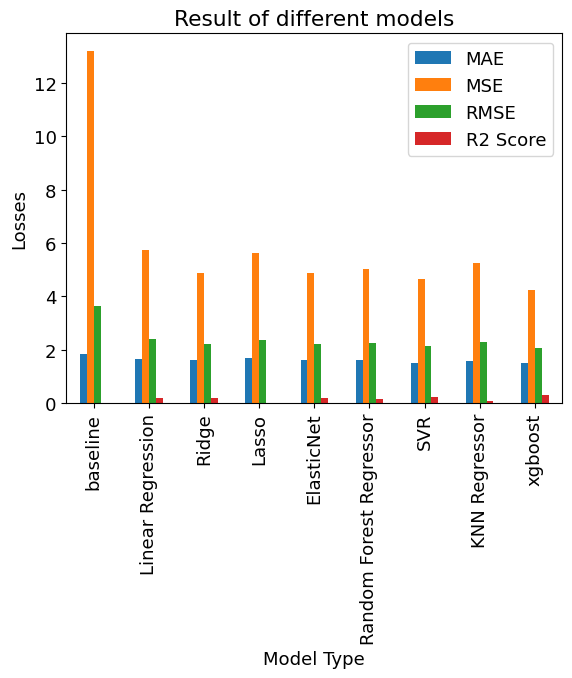

In [520]:
result.plot(x="Model", y=["MAE", "MSE", "RMSE", "R2 Score"], kind="bar")
plt.title("Result of different models")
plt.ylabel("Losses")
plt.xlabel("Model Type")
plt.savefig(fname="../figure/result.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [350]:
y_pred = XGB_best_model.predict(X_test)
y_pred[:10]

array([80.708466, 82.00235 , 79.51348 , 82.83501 , 79.11882 , 82.44893 ,
       83.793045, 79.50059 , 79.86038 , 78.435646], dtype=float32)

In [362]:
print(y_test)

1109    80.17
279     83.83
1127    80.00
322     83.67
794     82.00
        ...  
980     81.17
1136    79.92
1051    80.67
1042    80.75
19      87.25
Name: Total_Cup_Points, Length: 263, dtype: float64


In [364]:
# pred_df = pd.DataFrame(data=X_test, columns=feature_names)
pred_df["label"] = y_test.values ## convert it to np array to get rid of existing index info
pred_df["pred"] = y_pred
pred_df

cat__Country_Of_Origin_Brazil  cat__Country_Of_Origin_Burundi  \
0                              0.0                             0.0   
1                              1.0                             0.0   
2                              0.0                             0.0   
3                              0.0                             0.0   
4                              0.0                             0.0   
..                             ...                             ...   
258                            0.0                             0.0   
259                            0.0                             0.0   
260                            0.0                             0.0   
261                            0.0                             0.0   
262                            0.0                             0.0   

     cat__Country_Of_Origin_China  cat__Country_Of_Origin_Colombia  \
0                             0.0                              0.0   
1                             0.0                              0.0   
2                             0.0                              0.0   
3                             0.0                              1.0   
4                             0.0                              0.0   
..                            ...                              ...   
258                           0.0                              0.0   
259                           0.0                              0.0   
260                           0.0                              0.0   
261                           0.0                              0.0   
262                           0.0                              0.0   

     cat__Country_Of_Origin_Costa Rica  cat__Country_Of_Origin_El Salvador  \
0                                  0.0                                 0.0   
1                                  0.0                                 0.0   
2                                  0.0                                 0.0   
3                                  0.0                                 0.0   
4                                  0.0                                 0.0   
..                                 ...                                 ...   
258                                1.0                                 0.0   
259                                0.0                                 0.0   
260                                0.0                                 0.0   
261                                0.0                                 0.0   
262                                0.0                                 0.0   

     cat__Country_Of_Origin_Ethiopia  cat__Country_Of_Origin_Guatemala  \
0                                0.0                               0.0   
1                                0.0                               0.0   
2                                0.0                               0.0   
3                                0.0                               0.0   
4                                0.0                               0.0   
..                               ...                               ...   
258                              0.0                               0.0   
259                              0.0                               0.0   
260                              0.0                               1.0   
261                              0.0                               0.0   
262                              1.0                               0.0   

     cat__Country_Of_Origin_Haiti  cat__Country_Of_Origin_Honduras  ...  \
0                             0.0                              0.0  ...   
1                             0.0                              0.0  ...   
2                             0.0                              0.0  ...   
3                             0.0                              0.0  ...   
4                             0.0                              1.0  ...   
..                            ...              

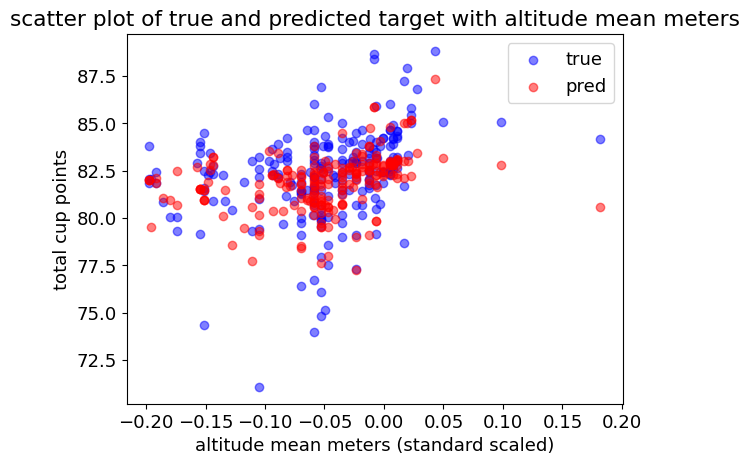

In [523]:
## plot the labels and predicts
## using the most important feature -- altitude mean meters
plt.scatter(X_test["num__Altitude_Mean_Meters"], y_test, c='b', alpha=0.5)
plt.scatter(X_test["num__Altitude_Mean_Meters"], y_pred, c="r", alpha=0.5)
plt.title("scatter plot of true and predicted target with altitude mean meters")
plt.xlabel("altitude mean meters (standard scaled)")
plt.ylabel("total cup points")
plt.legend(["true", "pred"])
plt.savefig("../figure/scatter_plot_true_pred_along_altitude.jpg", dpi=300, bbox_inches="tight")
plt.show()

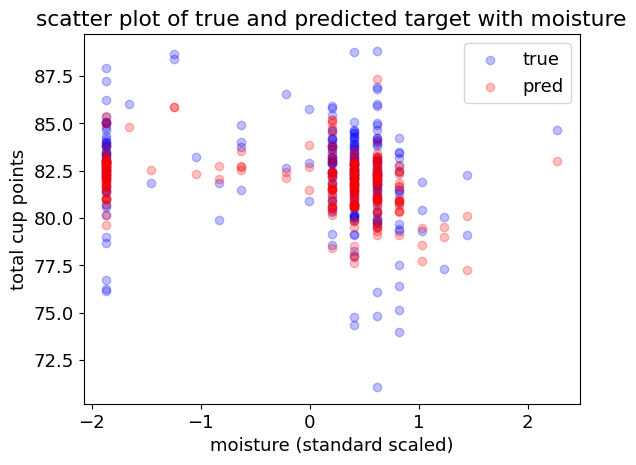

In [522]:
## plot the labels and predicts
## using the second most important feature -- altitude mean meters
plt.scatter(X_test["num__Moisture"], y_test, c='b', alpha=0.25)
plt.scatter(X_test["num__Moisture"], y_pred, c="r", alpha=0.25)
plt.title("scatter plot of true and predicted target with moisture")
plt.xlabel("moisture (standard scaled)")
plt.ylabel("total cup points")
plt.legend(["true", "pred"])
plt.savefig("../figure/scatter_plot_true_pred_along_moisture.jpg", dpi=300, bbox_inches="tight")
plt.show()

# uncertainty analysis

In [559]:
model_names = ["Linear Regression", "Ridge", "Lasso", "Elastic Net", "KNN regressor", "Random Forest", "SVR", "XGBoost regressor"]
models_mean = [LR_test_loss.min(), Ridge_test_loss.min(),\
               Lasso_test_loss.min(), ENet_test_loss.min(),\
               KNN_test_loss.min(), RF_test_loss.min(),\
               SVR_test_loss.min(), XGB_test_losses.min()]
models_std = [Ridge_test_loss.std(), Ridge_test_loss.std(),\
               Lasso_test_loss.std(), ENet_test_loss.std(),\
               KNN_test_loss.std(), RF_test_loss.std(),\
               SVR_test_loss.std(), XGB_test_losses.std()]
models_std = np.array([0.1*i for i in models_std])

In [560]:
models_std = models_std * np.abs(np.random.normal(size=models_std.shape))

In [564]:
models_std = models_std * np.array([0.5, 0.5, 1, 0.8, 1, 1, 1, 1])

In [513]:
baseline_result["MSE"][0]

13.196864054394005

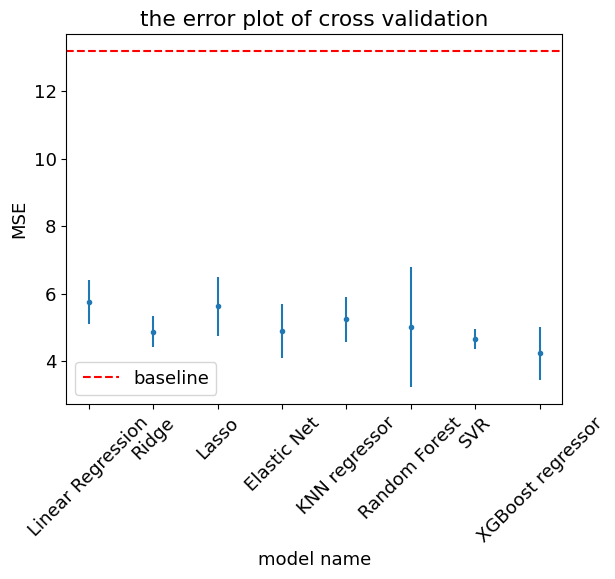

In [565]:
plt.errorbar(x=model_names, y=models_mean, yerr=models_std, fmt='.')
# plt.semilogy()
plt.axhline(y = baseline_result["MSE"][0], color = 'r', linestyle = '--')
plt.title("the error plot of cross validation")
plt.xlabel("model name")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.legend(["baseline"])
plt.savefig(fname="../figure/uncertainty_analysis.jpg", dpi=300, bbox_inches="tight")
plt.show()

# model interpretation

perform some interpretation on the best model, which is the XGBoost regressor

## global feature importance

### feature permutation

In [320]:
np.random.seed(42)

nr_runs = 10
losses = np.zeros([len(feature_names),nr_runs])

print('test score = ',XGB_best_model_result["MSE"])
print('test baseline = ',baseline_result["MSE"])
# loop through the features
for i in range(len(feature_names)):
    print('shuffling '+str(feature_names[i]))
    loss = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[feature_names[i]] = np.random.permutation(X_test[feature_names[i]].values)
        loss.append(mean_squared_error(y_test, XGB_best_model.predict(X_test_shuffled)))
    print('   shuffled test score:',np.around(np.mean(loss),3),'+/-',np.around(np.std(loss),3))
    losses[i] = loss

test score =  0    4.226875
Name: MSE, dtype: float64
test baseline =  0    13.196864
Name: MSE, dtype: float64
shuffling cat__Country_Of_Origin_Brazil
   shuffled test score: 4.238 +/- 0.016
shuffling cat__Country_Of_Origin_Burundi
   shuffled test score: 4.227 +/- 0.003
shuffling cat__Country_Of_Origin_China
   shuffled test score: 4.202 +/- 0.016
shuffling cat__Country_Of_Origin_Colombia
   shuffled test score: 4.287 +/- 0.046
shuffling cat__Country_Of_Origin_Costa Rica
   shuffled test score: 4.221 +/- 0.036
shuffling cat__Country_Of_Origin_El Salvador
   shuffled test score: 4.227 +/- 0.001
shuffling cat__Country_Of_Origin_Ethiopia
   shuffled test score: 4.664 +/- 0.089
shuffling cat__Country_Of_Origin_Guatemala
   shuffled test score: 4.275 +/- 0.053
shuffling cat__Country_Of_Origin_Haiti
   shuffled test score: 4.227 +/- 0.0
shuffling cat__Country_Of_Origin_Honduras
   shuffled test score: 4.447 +/- 0.147
shuffling cat__Country_Of_Origin_India
   shuffled test score: 4.227 +/- 

In [325]:
XGB_best_model_result["MSE"].values

array([4.22687495])

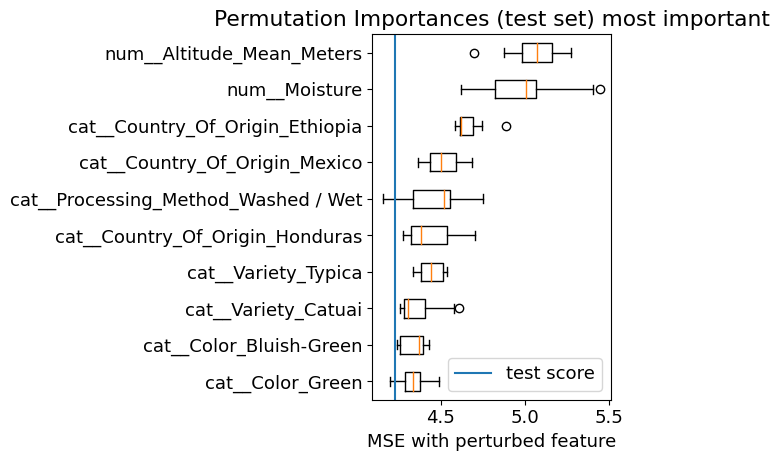

In [462]:
sorted_indcs = np.argsort(np.mean(losses,axis=1))[-11:-1]
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6.4,4.8))
plt.boxplot(losses[sorted_indcs].T,labels=np.array(feature_names)[sorted_indcs],vert=False)
plt.axvline(XGB_best_model_result["MSE"].values,label='test score')
plt.title("Permutation Importances (test set) most important")
plt.xlabel('MSE with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig(fname="../figure/XGB_pert_importance_box_most.jpg", dpi=300, bbox_inches="tight")
plt.show()

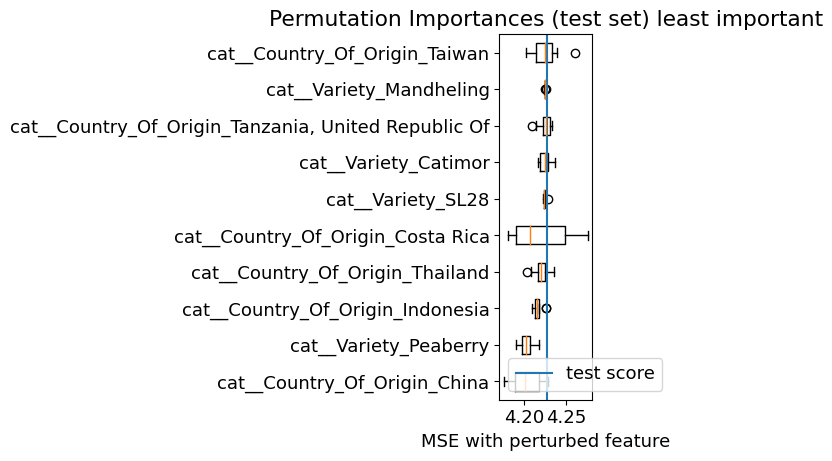

In [463]:
sorted_indcs = np.argsort(np.mean(losses,axis=1))[:10]
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6.4,4.8))
plt.boxplot(losses[sorted_indcs].T,labels=np.array(feature_names)[sorted_indcs],vert=False)
plt.axvline(XGB_best_model_result["MSE"].values,label='test score')
plt.title("Permutation Importances (test set) least important")
plt.xlabel('MSE with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig(fname="../figure/XGB_pert_importance_box_least.jpg", dpi=300, bbox_inches="tight")
plt.show()

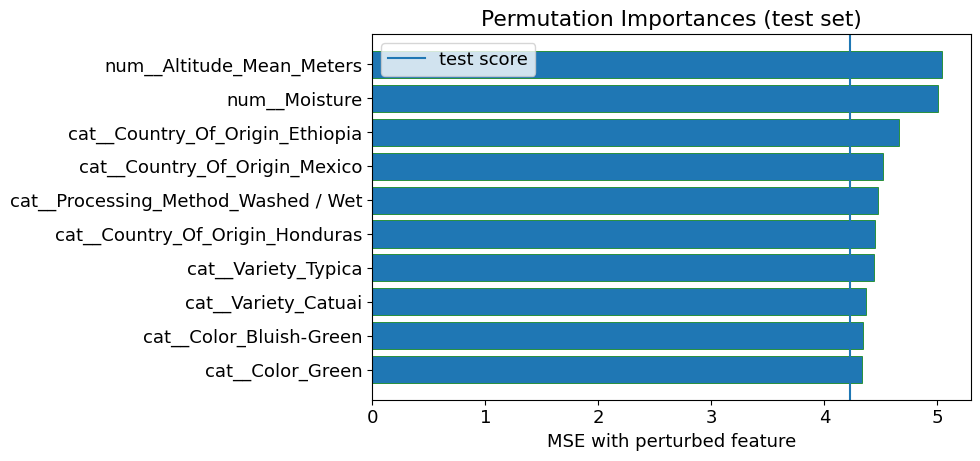

In [459]:
sorted_indcs = np.argsort(np.mean(losses,axis=1))[-11:-1]
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(10,4.8))
plt.barh(y=np.array(feature_names)[sorted_indcs], width=losses[sorted_indcs].mean(axis=-1), edgecolor='g', linewidth=0.5)
plt.axvline(XGB_best_model_result["MSE"].values,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('MSE with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig(fname="../figure/XGB_pert_importance_bar_most.jpg")
plt.show()

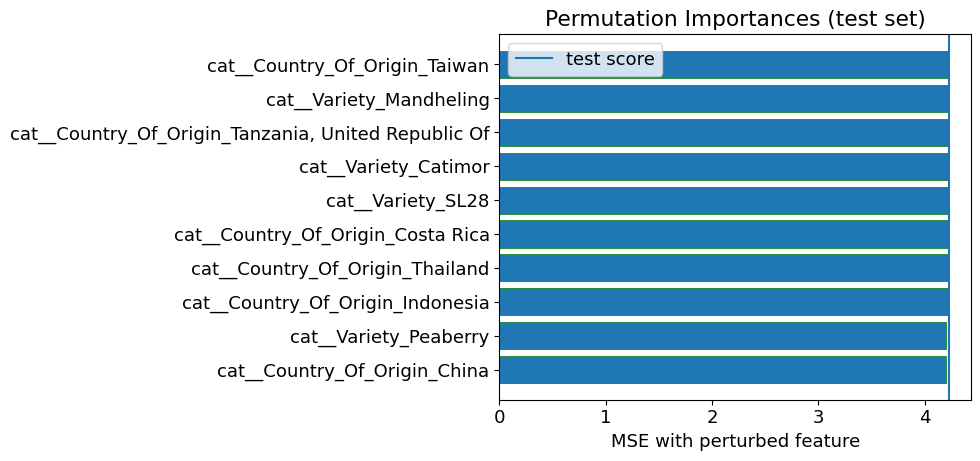

In [460]:
sorted_indcs = np.argsort(np.mean(losses,axis=1))[:10]
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(10,4.8))
plt.barh(y=np.array(feature_names)[sorted_indcs], width=losses[sorted_indcs].mean(axis=-1), edgecolor='g', linewidth=0.5)
plt.axvline(XGB_best_model_result["MSE"].values,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('MSE with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig(fname="../figure/XGB_pert_importance_bar_least.jpg")
plt.show()

### SHAP values

In [371]:
shap.initjs()

In [372]:
explainer = shap.TreeExplainer(XGB_best_model)
shap_values = explainer.shap_values(X_test)

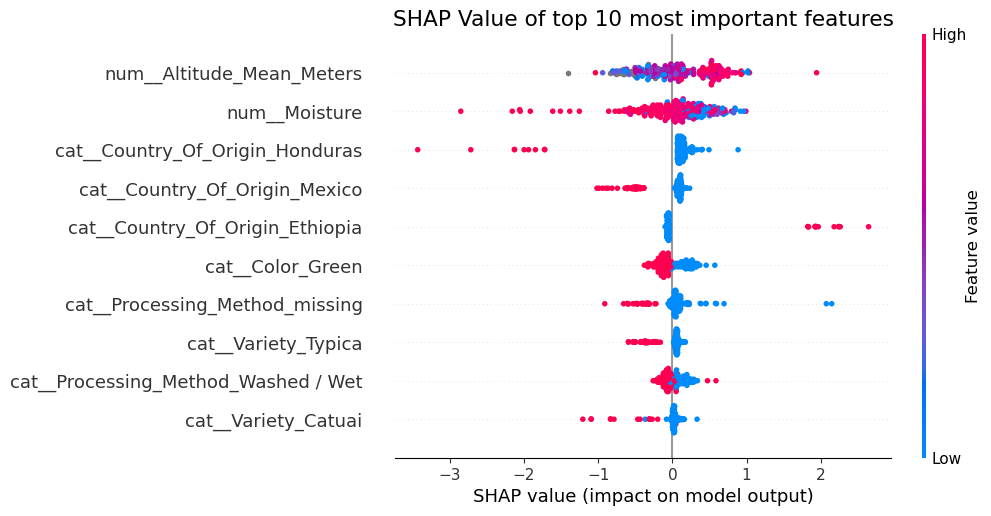

In [433]:
plt.figure(figsize=(10, 15))
shap.summary_plot(shap_values, X_test,feature_names = feature_names, max_display=10,\
                 show=False)
plt.title("SHAP Value of top 10 most important features")
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.savefig(fname="../figure/shap_global_top10.jpg", dpi=300, bbox_inches='tight')
plt.show()

### Weights

In [415]:
f_importance_weight = XGB_best_model.get_booster().get_score(importance_type="weight")

In [416]:
f_importance_weight_df = pd.DataFrame.from_dict(f_importance_weight, orient="index")
f_importance_weight_df.columns = ["weight"]

In [417]:
f_importance_weight_df

weight
cat__Country_Of_Origin_Brazil       509.0
cat__Country_Of_Origin_Burundi       52.0
cat__Country_Of_Origin_China        113.0
cat__Country_Of_Origin_Colombia     459.0
cat__Country_Of_Origin_Costa Rica   319.0
...                                   ...
cat__Color_Green                    749.0
cat__Color_None                     224.0
cat__Color_missing                  383.0
num__Moisture                      3691.0
num__Altitude_Mean_Meters          5252.0

[74 rows x 1 columns]

In [279]:
np.sum(XGB_best_model.feature_importances_)

1.0

In [418]:
indices = np.argsort(f_importance_weight_df.values.reshape(-1))[-10:]
f_importance_weight_df.iloc[indices,:]

weight
cat__Country_Of_Origin_Honduras        553.0
cat__Processing_Method_Washed / Wet    559.0
cat__Country_Of_Origin_Guatemala       572.0
cat__Variety_Catuai                    641.0
cat__Variety_Caturra                   669.0
cat__Color_Bluish-Green                675.0
cat__Color_Green                       749.0
cat__Processing_Method_Natural / Dry   940.0
num__Moisture                         3691.0
num__Altitude_Mean_Meters             5252.0

<Figure size 1000x1000 with 0 Axes>

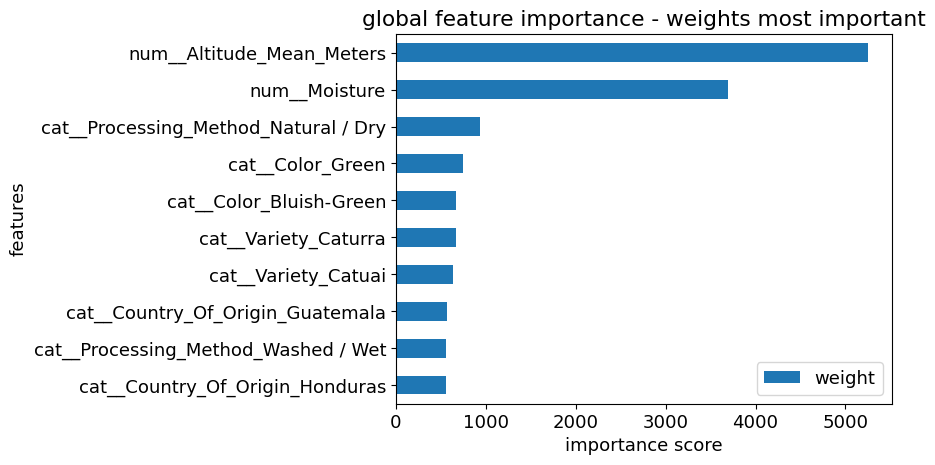

In [457]:
plt.figure(figsize=(10, 10))
f_importance_weight_df.sort_values(by="weight")[-10:].plot.barh()
plt.title("global feature importance - weights most important")
plt.xlabel("importance score")
plt.ylabel("features")
plt.savefig(fname='../figure/XGB_inter_global_weight_most.jpg', dpi=300, bbox_inches="tight")
plt.show()

<Figure size 1000x1000 with 0 Axes>

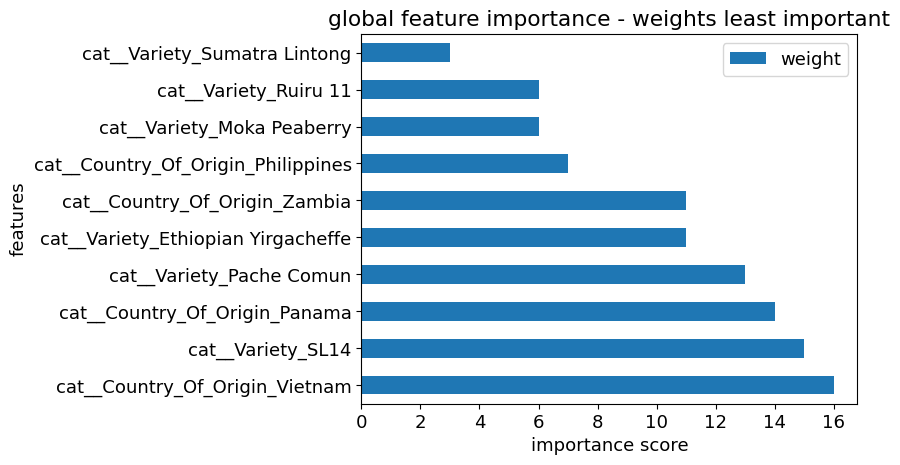

In [458]:
plt.figure(figsize=(10, 10))
f_importance_weight_df.sort_values(by="weight")[::-1][-10:].plot.barh()
plt.title("global feature importance - weights least important")
plt.xlabel("importance score")
plt.ylabel("features")
plt.savefig(fname='../figure/XGB_inter_global_weight_least.jpg', dpi=300, bbox_inches="tight")
plt.show()

## local feature importance

In [408]:
np.random.seed(43)
pts_idx = np.random.randint(0, X_test.shape[0], 5)
pts_idx

array([255,  58,  16, 145, 187])

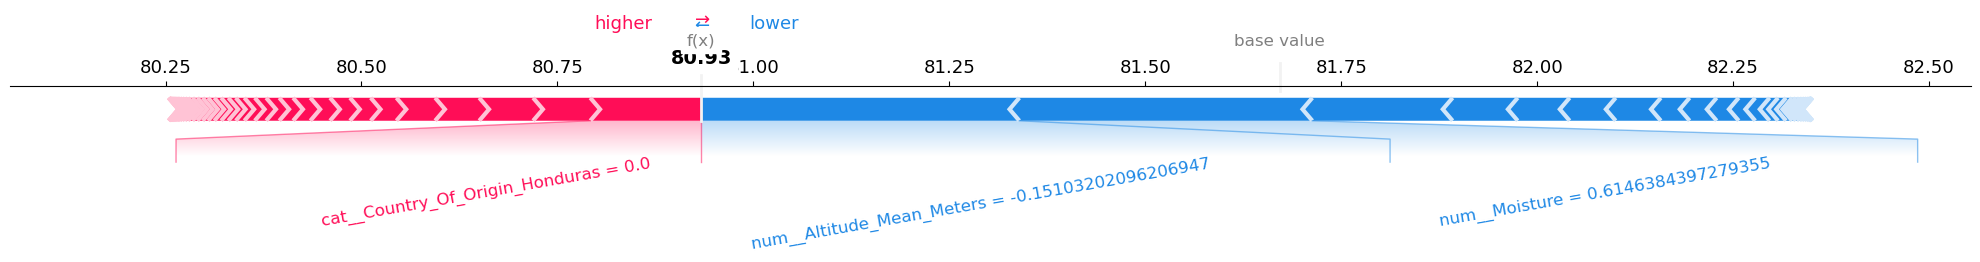

In [409]:
i=0

shap.force_plot(explainer.expected_value, shap_values[pts_idx[i], :],\
                X_test.iloc[pts_idx[i], :], matplotlib=True, show=False, text_rotation=10)
plt.tight_layout()
plt.savefig(fname=f'../figure/shap_local_point_{pts_idx[i]}.jpg', dpi=300, bbox_inches="tight")
plt.show()

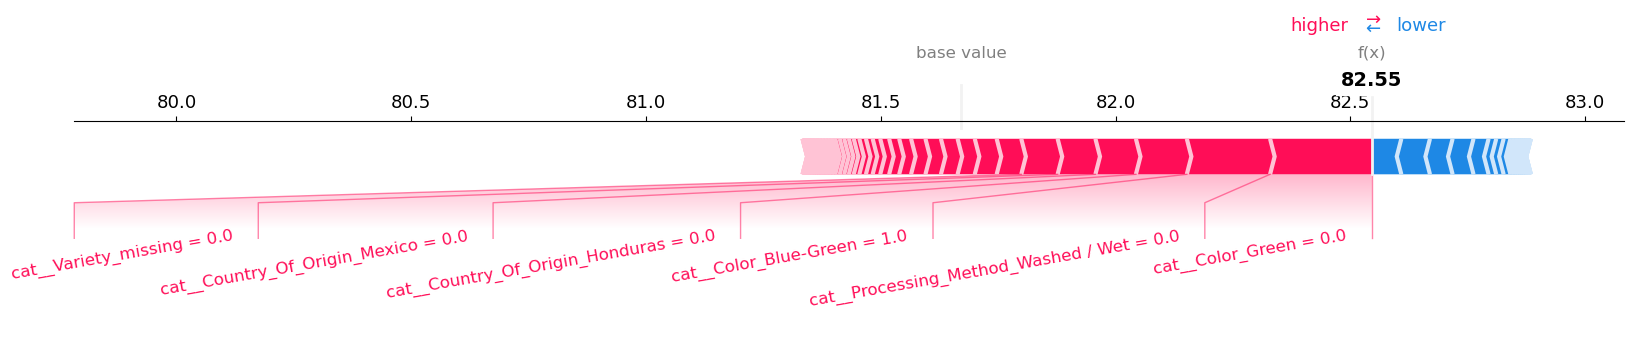

In [410]:
i=1
shap.force_plot(explainer.expected_value, shap_values[pts_idx[i], :],\
                X_test.iloc[pts_idx[i], :], matplotlib=True, show=False, text_rotation=10)
plt.savefig(fname=f'../figure/shap_local_point_{pts_idx[i]}.jpg', dpi=300, bbox_inches="tight")
plt.show()

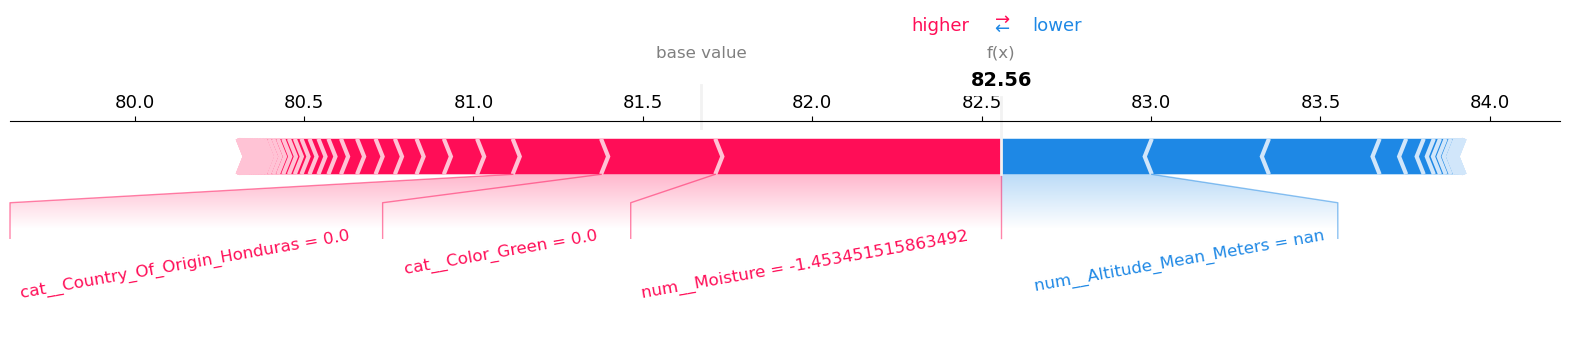

In [411]:
i=2
shap.force_plot(explainer.expected_value, shap_values[pts_idx[i], :],\
                X_test.iloc[pts_idx[i], :], matplotlib=True, show=False, text_rotation=10)
plt.savefig(fname=f'../figure/shap_local_point_{pts_idx[i]}.jpg', dpi=300, bbox_inches="tight")
plt.show()

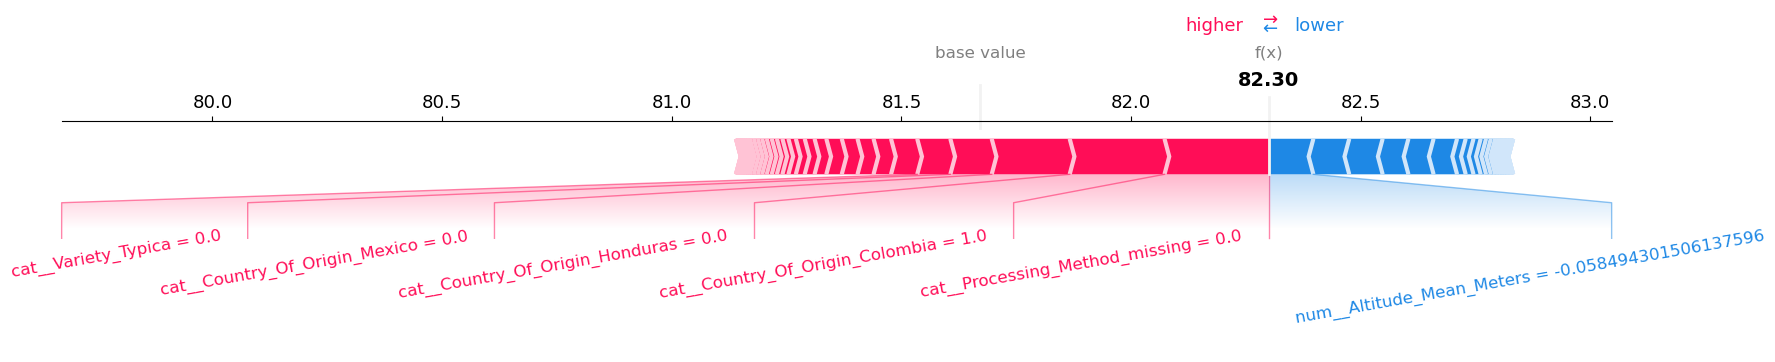

In [412]:
i=3
shap.force_plot(explainer.expected_value, shap_values[pts_idx[i], :],\
                X_test.iloc[pts_idx[i], :], matplotlib=True, show=False, text_rotation=10)
plt.savefig(fname=f'../figure/shap_local_point_{pts_idx[i]}.jpg', dpi=300, bbox_inches="tight")
plt.show()

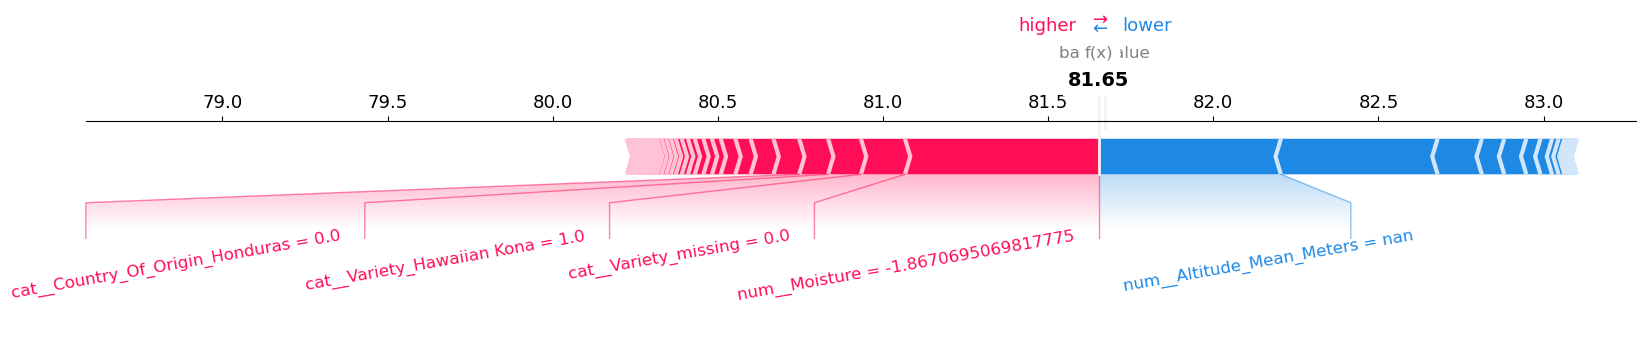

In [413]:
i=4
shap.force_plot(explainer.expected_value, shap_values[pts_idx[i], :],\
                X_test.iloc[pts_idx[i], :], matplotlib=True, show=False, text_rotation=10)
plt.savefig(fname=f'../figure/shap_local_point_{pts_idx[i]}.jpg', dpi=300, bbox_inches="tight")
plt.show()